# 台風発電船の運用シミュレーションプログラム

In [63]:
"""
############################ 台風発電シミュレーション ############################

##### 説明 ###################################################################

このモジュールは台風発電船の運用をシミュレーションするためのものです。
台風予想進路を作成するクラスと台風発電船のエージェントを設定するクラスから成ります。
外部入力として最低限過去の台風の座標と対応する時刻、台風を判別できる番号のデータが必要です。
それに加えてそれぞれのクラス変数に数値を定義することで動かすことができます。
時刻ごとに台風発電船の状態量を記録することでシミュレーションを可視化するデータが得られます。
最後の状態量のみ抜き出せば、1年間の運用の結果のみを見ることができます。
台風発電船の状態量についてはclass TPGshipで説明します。

##### TODOリスト #############################################################

  ・等時間幅の過去の台風の座標とそれに対応する時刻のデータ(csv)を用意する
  ・class Forecaster では2つ、class TPGshipでは3つクラス変数を定義する
  ・拠点位置、待機位置、forecast_weightの3つのインスタンス変数の定義が今回必要
  （↑初期入力で適当な値を入れてしまったほうが良い？）

#############################################################################
"""

import polars as pl
#import pandas as pd
import numpy as np
from turtle import distance
import csv
import math
import geopy as gp
import folium as fl
import matplotlib.pyplot as plt
import japanize_matplotlib
import os
from geopy.distance import geodesic
from geopy.point import Point
from geographiclib.geodesic import Geodesic
from datetime import datetime, timedelta, timezone
from dateutil import tz
import random
from matplotlib import pyplot as pyp

クラスを定義する

In [64]:
#各国や各組織の進路予報を使用することを想定して一応残しておく
#予想したデータを受け渡す役割を持つのでForecasterとした
#現状は真のデータから期間分のデータを取り出すこと以外の能力はない
class Forecaster():

    """
    ############################## class Forecaster ##############################

    [ 説明 ]

    このクラスは台風発電船が行動を判断するのに用いる「予報データ」を作成するものです。

    クラス変数で予報の範囲と大まかな精度を指定することができます。

    ##############################################################################

    引数 :
        time_step (int) : シミュレーションにおける時間の進み幅[hours]
        current_time (int) : シミュレーション上の現在時刻(unixtime)

    属性 :
        forecast_time (int) : 予報の範囲(期間)を設定する。単位は時間[hours]。
        slope (float) : 予報の誤差距離を設定する。時間を変数とする1次関数の傾きであり遠い時間
                        ほど誤差が大きくなる。
        original_data (dataflame) : 過去の台風の座標とそれに対応する時刻を保有するデータ

    #############################################################################
    """
    
    forecast_time = 24*365
    slope = 0.1

    def cal_error_radius_km(self,time_step,advance_time_hour):

        """
        ########################## def cal_error_radius_km ##########################

        [ 説明 ]

        誤差距離[km]を計算する関数です。前提として、時間の進み幅分1つ進んだ(例：時間の進み幅が6時間

        なら6時間後)の時間の誤差距離は0kmとします。設定した傾き(slope)の1次関数で現在時刻から進めた

        時間より誤差距離を算出します。

        予報の座標を出す際に正規分布に従ってoriginal_dataの座標からランダムに点を出しますが、その正

        規分布の設定における標準偏差の算出に使われる数値となります。

        ##############################################################################

        引数 :
            advance_time_hour (int) : シミュレーション上の現在時刻に対し進めた時間[hours]

        戻り値 :
            error_radius_km (int) : その時刻の正確な座標からの平均的な座標のずれ[km]

        #############################################################################
        """

        error_radius_km = self.slope*(advance_time_hour - time_step)
        return error_radius_km

    #sd : standerd deviation 標準偏差
    def cal_forecast_point_lat_sd(self,error_radius_km,original_point):

        """
        ####################### def cal_forecast_point_lat_sd #######################

        [ 説明 ]

        関数 create_forecast で用いる緯度の標準偏差を計算するための関数です。

        誤差距離がkm単位で与えられるのに対し、正規分布で座標を求めるために緯度経度の度数が単位の数値

        が必要となります。ここでは誤差距離をkm単位から度数単位に変換することを行なっています。これが

        求める標準偏差そのものになります。適度な度数の幅を定め、その幅で緯度のみをずらしながら誤差距

        離に近くなるまでずらします。誤差距離に近くなった時の緯度とずらされる前の緯度の差がkmを度数に

        置き換えた数値になります。これを緯度の標準偏差として用います。

        わざわざこのようにして求めているのは緯度1度、経度1度の長さは緯度によって変わってしまうからで

        す。緯度は比較的差が小さいですが経度は大きいため緯度に対応し都度求める必要があります。

        ##############################################################################

        引数 :
            error_radius_km (int) : その時刻の正確な座標からの平均的な座標のずれ[km](誤差距離)
            original_point (tuple) : original_dataにおける該当時刻の台風の座標
            

        戻り値 :
            lat_sd (float) : 緯度の標準偏差として用いられる値。distanceが誤差距離にほぼ等しい時
                             のtemp_latとoriginal_point_latの差

        #############################################################################
        """

        original_point_lat = original_point[0]
        original_point_lon = original_point[1]
        distance = 0

        #緯度1度分の距離がだいたい110〜112km
        #1kmの場合の度数を(1/112)とし、誤差距離の30分の1ずつ調べることとする
        split_deg_num = (1 / 112) * (error_radius_km / 30)
        temp_lat = original_point_lat
        
        while distance < error_radius_km:
            temp_lat = temp_lat + split_deg_num
            temp_point = (temp_lat,original_point_lon)

            distance = geodesic(original_point,temp_point).km   
        
        lat_sd = temp_lat - original_point_lat

        return lat_sd

    
    def cal_forecast_point_lon_sd(self,error_radius_km,original_point):

        """
        ####################### def cal_forecast_point_lon_sd #######################

        [ 説明 ]

        関数 create_forecast で用いる経度の標準偏差を計算するための関数です。

        誤差距離がkm単位で与えられるのに対し、正規分布で座標を求めるために緯度経度の度数が単位の数値

        が必要となります。ここでは誤差距離をkm単位から度数単位に変換することを行なっています。これが

        求める標準偏差そのものになります。適度な度数の幅を定め、その幅で経度のみをずらしながら誤差距

        離に近くなるまでずらします。誤差距離に近くなった時の経度とずらされる前の経度の差がkmを度数に

        置き換えた数値になります。これを経度の標準偏差として用います。

        わざわざこのようにして求めているのは緯度1度、経度1度の長さは緯度によって変わってしまうからで

        す。緯度は比較的差が小さいですが経度は大きいため緯度に対応し都度求める必要があります。

        #############################################################################

        引数 :
            error_radius_km (int) : その時刻の正確な座標からの平均的な座標のずれ[km](誤差距離)
            original_point (tuple) : original_dataにおける該当時刻の台風の座標
            

        戻り値 :
            lon_sd (float) : 緯度の標準偏差として用いられる値。distanceが誤差距離にほぼ等しい時
                             のtemp_lonとoriginal_point_lonの差

        #############################################################################
        """

        original_point_lat = original_point[0]
        original_point_lon = original_point[1]
        distance = 0

        #経度1度分の距離がだいたい北緯0で112km、北緯70で38km
        #1kmの場合の度数を(1/112)とし、誤差距離の30分の1ずつ調べることとする
        split_deg_num = (1 / 112) * (error_radius_km / 30)
        lon = original_point_lon
        
        while distance < error_radius_km:
            lon = lon + split_deg_num
            temp_point = (original_point_lat,lon)

            distance = geodesic(original_point,temp_point).km   
        
        lon_sd = lon - original_point_lon
        
        return lon_sd
    


    def create_forecast(self , time_step , current_time):

        """
        ############################ def create_forecast ############################

        [ 説明 ]

        関数 cal_error_radius_km , cal_forecast_point_lat_sd , cal_forecast_point_lon_sd
        
        を用いて、「予報データ」を作成する関数です。各時刻の台風の座標における緯度と

        経度それぞれで、original_dataの座標を平均値と関数を用いて算出した標準偏差の正規分布からラ

        ンダムに数値を出します。これによって得られた座標を予想座標として時刻、台風の番号とセットで記

        録します。current_timeからforecast_time期間分に存在するデータに対し、この処理を行なった

        ものを「予報データ」とします。

        ##############################################################################

        引数 :
            time_step (int) : シミュレーションにおける時間の進み幅[hours]
            current_time (int) : シミュレーション上の現在時刻(unixtime)
            

        戻り値 :
            forecast_data (dataflame) : 時刻、台風の番号、予想座標を持つ予報データ

        #############################################################################
        """

        unix_forecast_time = self.forecast_time * 3600
        start_forecast_time = current_time + time_step*3600
        last_forecast_time = current_time + unix_forecast_time

        forecast_true_data = self.original_data.filter((pl.col("unixtime") >= start_forecast_time)&(pl.col("unixtime") <= last_forecast_time))

        unix_list = []
        ty_num_list = []
        lat_list = []
        lon_list = []

        forecast_lat_list = []
        forecast_lon_list = []

        #unix,ty_num,lat,lonが少なくともあれば良い
        rep_num = len(forecast_true_data)
        

        if rep_num != 0:
            for i in range(rep_num):
                unix_list.append(forecast_true_data[i,"unixtime"])
                ty_num_list.append(forecast_true_data[i,"TYPHOON NUMBER"])
                lat_list.append(forecast_true_data[i,"LAT"])
                lon_list.append(forecast_true_data[i,"LON"])
                

                true_point = (lat_list[i],lon_list[i])

                advance_time_hour = (unix_list[i] - current_time)/3600
                error_radius_km = self.cal_error_radius_km(time_step,advance_time_hour)

                lat_sd = self.cal_forecast_point_lat_sd(error_radius_km,true_point)
                lon_sd = self.cal_forecast_point_lon_sd(error_radius_km,true_point)

                forecast_lat = random.gauss(lat_list[i],lat_sd)
                forecast_lon = random.gauss(lon_list[i],lon_sd)

                forecast_lat_list.append(forecast_lat)
                forecast_lon_list.append(forecast_lon)
        
        forecast_data = pl.DataFrame({"unixtime":unix_list,"TYPHOON NUMBER":ty_num_list,"TRUE_LAT":lat_list,"TRUE_LON":lon_list,"FORE_LAT":forecast_lat_list,"FORE_LON":forecast_lon_list})
        #forecast_data.columns=["unixtime","TYPHOON NUMBER","TRUE_LAT","TRUE_LON","FORE_LAT","FORE_LON"]

        
        return forecast_data

    
    



In [65]:
class support_SHIP():

    ship_gene = 0
    max_storage = 0
    storage = 0
    arrived_supplybase = 1
    arrived_storagebase = 0
    support_ship_speed = 5

    #高砂水素パーク
    supplybase_lat = 34.75
    supplybase_lon = 134.79
    
    ship_lat = supplybase_lat
    ship_lon = supplybase_lon
    target_lat = np.nan
    target_lon = np.nan
    brance_condition = "no action"
    ship_gene = 0

    def set_outputs(self):
        """
        ############################ def set_outputs ############################

        [ 説明 ]

        補助船の出力を記録するリストを作成する関数です。

        ##############################################################################

        """
        self.unix_list = []
        self.date_list = []
        self.sp_target_lat_list = []
        self.sp_target_lon_list = []
        self.sp_storage_list = []
        self.sp_st_per_list = []
        self.sp_ship_lat_list = []
        self.sp_ship_lon_list = []
        self.sp_brance_condition_list = []


    def outputs_append(self,current_time):
        """
        ############################ def outputs_append ############################

        [ 説明 ]

        set_outputs関数で作成したリストに出力を記録する関数です。

        ##############################################################################

        """
        UTC = timezone(timedelta(hours =+ 0),"UTC")
        self.unix_list.append(current_time)
        self.date_list.append(datetime.fromtimestamp(self.unix_list[-1],UTC))
        self.sp_target_lat_list.append(float(self.target_lat))
        self.sp_target_lon_list.append(float(self.target_lon))
        self.sp_storage_list.append(float(self.storage))
        self.sp_st_per_list.append(float(self.storage/self.max_storage*100))
        self.sp_ship_lat_list.append(float(self.ship_lat))
        self.sp_ship_lon_list.append(float(self.ship_lon))
        self.sp_brance_condition_list.append(self.brance_condition)
    
    

    #状態量計算
    def get_distance(self,storage_base_position):
        
        """
        ############################ def get_distance ############################

        [ 説明 ]

        補助船(または拠点位置or観測地点)からUUVへの距離を計算する関数です。

        ##############################################################################

        引数 :
            storage_base_position (taple) : 中継貯蔵拠点の座標(緯度,経度)
            

        戻り値 :
            distance (float) : 補助船から上記拠点への距離(km)

        #############################################################################
        """
        
        A_position = (self.ship_lat,self.ship_lon)

        #AーB間距離
        distance = geodesic(A_position,storage_base_position).km
    
        return distance 




    #状態量計算
    def change_kt_kmh(self):

        """
        ############################ def change_kt_kmh ############################

        [ 説明 ]

        ktをkm/hに変換する関数です

        ##############################################################################
            

        戻り値 :
            speed_kmh (float) : km/hに変換された船速

        #############################################################################
        """

        speed_kmh = self.speed_kt * 1.852
    
        return speed_kmh

    

    #拠点または観測地点からuuvまでの距離取得
    def get_base_dis_data(self,storage_base_position):

        """
        ############################ def get_base_dis_data ############################

        [ 説明 ]

        get_target_dataで選ばれ、追従対象となった台風のcurrent_time + time_stepの時刻での座標を取得する関数です。

        存在しない場合は空のデータフレームが返ります。

        本関数は複数の供給拠点が本土にある場合に初めて有効となる。今後の拡張を見越し、事前実装する。

        課題点としては、各拠点で運用される補助船がおそらく共通化してしまうことである。
        
        コスト計算をするなら拠点ごとに設定する必要がある。

        ##############################################################################

        引数 :
            current_time (int) : シミュレーション上の現在時刻[unixtime]
            time_step (int) : シミュレーションにおける時間の進み幅[hours]
            storage_base_position (taple) : 中継貯蔵拠点の座標(緯度,経度)
            

        戻り値 :
            self.route_plus_dis_data (dataflame) : 供給拠点または中継貯蔵拠点からの距離が追加されたデータ

        #############################################################################
        """
        distance_list = []
        
        
        if len(self.base_data) != 0:
            for i in range(len(self.base_data)):

                A_position = (self.base_data[i,"LAT"],self.base_data[i,"LON"])
                distance = geodesic(A_position,storage_base_position).km
                distance_list.append(distance)
            
            #台風の距離を一応書いておく
            base_plus_dis_data = self.base_data.with_columns(pl.Series(distance_list).alias("distance"))

            #距離が近い順番に並び替え
            base_plus_dis_data = base_plus_dis_data.select(pl.col("*").sort_by("distance",descending = False))
        
        return base_plus_dis_data

        


    #状態量計算
    #次の時刻での船の座標
    def get_next_position(self, time_step):

        """
        ############################ def get_next_position ############################

        [ 説明 ]

        補助船の次の時刻での座標を計算するための関数です。

        現在地から目標地点まで直線に進んだ場合にいる座標を計算して返します。

        補助船が次の時刻で目的地に到着できる場合は座標は目的地のものになります。

        状態量が更新されるのみなのでreturnでの戻り値はありません。

        ##############################################################################

        引数 :
            time_step (int) : シミュレーションにおける時間の進み幅[hours]
            

        #############################################################################
        """

        target_position = (self.target_lat,self.target_lon)

        #目的地と現在地の距離
        Goal_now_distance = self.get_distance(target_position) #[km]

        #船がtime_step時間で進める距離
        advance_distance = self.change_kt_kmh() * time_step

        #緯度の差
        g_lat = self.target_lat
        n_lat = self.ship_lat

        lat_difference = g_lat - n_lat

        #経度の差
        g_lon = self.target_lon
        n_lon = self.ship_lon

        lon_difference = g_lon - n_lon

        #進める距離と目的地までの距離の比を出す
        if Goal_now_distance != 0 :
            distance_ratio = advance_distance / Goal_now_distance
        else:
            distance_ratio = 0

        #念の為の分岐
        #距離の比が1を超える場合目的地に到着できることになるので座標を目的地へ、そうでないなら当該距離進める
        
        if distance_ratio < 1 and distance_ratio > 0 :
            
            #次の時間にいるであろう緯度
            next_lat = lat_difference * distance_ratio + n_lat

            #次の時間にいるであろう経度
            next_lon = lon_difference * distance_ratio + n_lon

        else :

            #次の時間にいるであろう緯度
            next_lat = g_lat

            #次の時間にいるであろう経度
            next_lon = g_lon

        
        next_position = (next_lat , next_lon)
        self.ship_lat = next_lat
        self.ship_lon = next_lon


    #まだ使わないver5では拠点は1つ
    def set_start_position(self,storage_base_position):
        
        self.change_ship = 0
        self.base_plus_dis_data = self.get_base_dis_data(storage_base_position)
        if not np.isnan(self.ship_lat):
            uuv_ship_dis = self.get_distance(storage_base_position)
            if uuv_ship_dis > self.base_plus_dis_data[0,"distance"]:
                self.change_ship = 1
                #self.ship_lat = self.route_plus_dis_data[0,"LAT"]
                #self.ship_lon = self.route_plus_dis_data[0,"LON"]
                #self.base_lat = self.route_plus_dis_data[0,"LAT"]
                #self.base_lon = self.route_plus_dis_data[0,"LON"]
            else:
            #更新なし、その場からuuvへ向かう
                self.ship_gene = 1
                self.arrived_supplybase = 0
                self.arrived_storagebase = 0

                self.target_lat = storage_base_position[0]
                self.target_lon = storage_base_position[1]
        
        else:
            self.ship_lat = self.base_plus_dis_data[0,"LAT"]
            self.ship_lon = self.base_plus_dis_data[0,"LON"]
            self.base_lat = self.base_plus_dis_data[0,"LAT"]
            self.base_lon = self.base_plus_dis_data[0,"LON"]
            self.arrived_supplybase = 0
            self.arrived_storagebase = 0
            self.ship_gene = 1
        

            self.target_lat = storage_base_position[0]
            self.target_lon = storage_base_position[1]

    def go_storagebase_action(self,storage_base_position,time_step):

        """
        ############################ def get_next_ship_state ############################

        [ 説明 ]

        UUVが拠点に帰港する場合の基本的な行動をまとめた関数です。

        行っていることは、目的地の設定、行動の記録、船速の決定、到着の判断です。

        ##############################################################################

        引数 :
            time_step (int) : シミュレーションにおける時間の進み幅[hours]
            

        #############################################################################
        """


        #帰港での船速の入力
        self.speed_kt = self.support_ship_speed

        self.target_lat = storage_base_position[0]
        self.target_lon = storage_base_position[1]
        
        storagebase_ship_dis_time = self.get_distance(storage_base_position)/self.change_kt_kmh()
        self.arrived_storagebase = 0
        self.arrived_supplybase = 0

        #timestep後にUUVに船がついている場合
        if storagebase_ship_dis_time <= time_step:
            self.brance_condition = "arrival at storage Base"
            self.arrived_storagebase = 1 #到着のフラグ
            self.arrived_supplybase = 0
            self.ship_lat = storage_base_position[0]
            self.ship_lon = storage_base_position[1]

            self.speed_kt = 0

            
        
        else:
            self.brance_condition = "go to storage Base"
            self.arrived_storagebase = 0


    def go_supplybase_action(self,time_step):

        """
        ############################ def go_supplybase_action ############################

        [ 説明 ]

        補助船が供給拠点に帰港する場合の基本的な行動をまとめた関数です。

        行っていることは、目的地の設定、行動の記録、船速の決定、到着の判断です。

        ##############################################################################

        引数 :
            time_step (int) : シミュレーションにおける時間の進み幅[hours]
            

        #############################################################################
        """


        #帰港での船速の入力
        self.speed_kt = self.support_ship_speed
        self.target_lat = self.supplybase_lat
        self.target_lon = self.supplybase_lon
        supplybase_position = (self.supplybase_lat,self.supplybase_lon)
        uuv_ship_dis_time = self.get_distance(supplybase_position)/self.change_kt_kmh()
        self.arrived_supplybase = 0

        #timestep後にBaseに船がついている場合
        if uuv_ship_dis_time <= time_step:
            self.brance_condition = "arrival at supply Base"
            self.ship_gene = 0
            self.arrived_supplybase = 1 #到着のフラグ
            self.arrived_storagebase = 0 #履歴削除
            self.ship_lat = self.supplybase_lat
            self.ship_lon = self.supplybase_lon
            self.target_lat = np.nan
            self.target_lon = np.nan
            self.target_distance = np.nan
            self.storage = 0

            self.speed_kt = 0

            
        
        else:
            self.brance_condition = "go to supply Base"
            self.arrived_supplybase = 0
    
    def get_next_ship_state(self,storage_base_position,year,current_time,time_step):

        if (self.arrived_storagebase == 0) and (self.arrived_supplybase == 1):
            self.go_storagebase_action(storage_base_position,time_step)
        elif (self.arrived_storagebase == 1) and (self.arrived_supplybase == 0):
            self.go_supplybase_action(time_step)
        elif (self.arrived_storagebase == 0) and (self.arrived_supplybase == 0):
            self.go_storagebase_action(storage_base_position,time_step)
        else:
            self.arrived_supplybase = 0
            self.arrived_storagebase = 0
        
        #拠点に帰った場合を弾く
        if not np.isnan(self.target_lat):
            self.get_next_position(time_step)

            #目標地点との距離
            target_position = (self.target_lat,self.target_lon)
            self.target_distance = self.get_distance(target_position)
             




In [66]:
#TPGship = Typhoon Power Generation ship
class TPGship():
    """
    ############################### class TPGship ###############################

    [ 説明 ]

    このクラスは台風発電船を作成するクラスです。台風発電船の行動とその行動をするための条件を定義します。

    台風発電船自体の能力や状態量もここで定義されることになります。

    ##############################################################################

    引数 :
        year (int) : シミュレーションを行う年
        time_step (int) : シミュレーションにおける時間の進み幅[hours]
        current_time (int) : シミュレーション上の現在時刻(unixtime)

    属性 :
        max_storage (float) : 台風発電船の蓄電容量の上限値
        generator_output (float) : 台風発電船の定格出力
        wind_propulsion_power (float) : 通常海域で台風発電船の風力推進機で得られる平均出力
        generator_drag_work (float) : 停止状態の発電機を船体と最大船速で推進させるために必要な出力または稼働状態の発電機を発電船速で推進させるために必要な出力
        max_speed_power (float) : 付加物のない船体を最大船速で進めるのに必要な出力


        storage (float) : 台風発電船のその時刻での蓄電量
        storage_percentage (float) : 台風発電船のその時刻での蓄電量の割合
        gene_elect (float) : その時刻での発電量
        loss_elect (float) : その時刻での消費電力量
        ship_state (int) : 台風発電船の状態。通常航行、待機=0,発電状態=1,台風追従=2,台風低速追従=2.5,拠点回航=3,待機位置回航=4。
        total_gene_elect (float) : その時刻までの合計発電量
        total_loss_elect (float) : その時刻までの合計消費電力量
        total_gene_time (int) : その時刻までの合計発電時間
        total_loss_time (int) : その時刻までの合計電力消費時間

        speed_kt (float) : その時刻での台風発電船の船速(kt)
        target_name (str) : 目標地点の名前。台風の場合は番号の文字列入力。
        base_lat (float) : 拠点の緯度　※現段階では外部から入力が必要。調査で適当な値が求まったらそれを初期代入する予定。
        base_lon (float) : 拠点の経度　※現段階では外部から入力が必要。調査で適当な値が求まったらそれを初期代入する予定。
        standby_lat (float) : 待機位置の緯度　※現段階では外部から入力が必要。調査で適当な値が求まったらそれを初期代入する予定。
        standby_lon (float) : 待機位置の経度　※現段階では外部から入力が必要。調査で適当な値が求まったらそれを初期代入する予定。
        ship_lat (float) : その時刻での台風発電船の緯度
        ship_lon (float) : その時刻での台風発電船の経度
        target_lat (float) : 目標地点の緯度
        target_lon (float) : 目標地点の経度
        target_distance (float) : 台風発電船から目標地点までの距離(km)
        target_TY (int) : 追従対象の台風の番号の整数入力。ない場合は0が入る。
        go_base (int) : 1の時その時の蓄電容量によらず拠点に帰る。
        next_TY_lat (float) : time_step後の目標台風の緯度。ない場合は経度と共に0
        next_TY_lon (float) : time_step後の目標台風の経度。ない場合は緯度と共に0
        next_ship_TY_dis (float) : time_step後の目標台風と台風発電船の距離(km)。ない場合はNaN。
        brance_condition (str) : 台風発電船が行動分岐のどの分岐になったかを示す

        distance_judge_hours (int) : 追従判断基準時間。発電船にとって台風が遠いか近いかを判断する基準。　※本プログラムでは使用しない
        judge_energy_storage_per (int) : 発電船が帰港判断をする蓄電割合。
        effective_range (float) : 発電船が台風下での航行となる台風中心からの距離[km]
        sub_judge_energy_storage_per (int) : 発電船が拠点経由で目的地に向かう判断をする蓄電割合。
        judge_direction (float) : 発電船が2つの目的地の方位差から行動を判断する時の基準値[度]
        standby_via_base (int) : 待機位置へ拠点を経由して向かう場合のフラグ
        judge_time_times (float) : 台風の補足地点に発電船が最大船速で到着する時間に対し台風が到着する時間が「何倍」である時追うと判断するのかの基準値

        normal_ave_speed (float) : 平常時の平均船速(kt)
        max_speed (float) : 最大船速(kt)
        TY_tracking_speed (float) : 台風を追いかける時の船速(kt)
        speed_kt (float) : その時の船速(kt)

        forecast_data (dataflame) : 各時刻の台風の予想座標がわかるデータ。台風番号、時刻、座標を持つ　※Forecasterからもらう必要がある。
        TY_start_time_list (list) : 全ての台風の発生時刻のリスト　※現段階では外部から入力が必要。調査で適当な値が求まったらそれを初期代入する予定。
        forecast_weight (float) : 台風を評価する際の式で各項につける重みの数値。他の項は(100-forecast_weight)。　※現段階では外部から入力が必要。調査で適当な値が求まったらそれを初期代入する予定。



    #############################################################################
    """

    ####################################  パラメータ  ######################################

    max_storage = 0
    generator_output = 0
    wind_trust_work = 0
    generator_drag_work = 0
    hull_drag_work = 0
    max_speed_power = 0
    air_density = 1.225

    
    

    ####################################  状態量  ######################################

    #状態量の初期値入力
    def set_initial_states(self):

        """
        ############################ def set_initial_states ############################

        [ 説明 ]

        台風発電船の各種状態量に初期値を与える関数です。

        max_storage , base_lat , base_lon , standby_lat , standby_lonの数値の定義が少なくとも先に必要です。

        ##############################################################################

        """

        #船内電気関係の状態量
        self.storage = 0
        self.storage_percentage = (self.storage / self.max_storage) * 100
        self.supply_elect = 0
        self.gene_elect = 0
        self.loss_elect = 0
        self.loss_work = 0
        self.ship_state = 0
        self.total_gene_elect = 0
        self.total_loss_elect = 0
        self.total_gene_time = 0
        self.total_loss_time = 0


        #発電船の行動に関する状態量(現状のクラス定義では外部入力不可(更新が内部関数のため))
        self.speed_kt = 0
        self.target_name = "base station"
        self.ship_lat = self.base_lat
        self.ship_lon = self.base_lon
        self.ship_lat_before = self.ship_lat
        self.ship_lon_before = self.ship_lon
        self.target_lat = self.base_lat
        self.target_lon = self.base_lon
        self.target_distance = 0
        self.target_TY = 0
        self.go_base = 0
        self.TY_and_base_action = 0
        self.next_TY_lat = 0
        self.next_TY_lon = 0
        self.next_ship_TY_dis = np.nan
        self.brance_condition = "start forecast"
        self.GS_gene_judge = 0

        #台風発電船の受ける風パラメータ
        self.wind_u = 0
        self.wind_v = 0
        self.wind_state = str("no")

        #硬翼帆に関するパラメータ
        self.sail_area = 880 # 帆一枚あたりの面積[m^2]
        #self.sail_num = 1 # 帆の枚数
        self.sail_steps = 5 # 帆の伸縮段数

        #発電機に関するパラメータ
        self.generator_c = 5 # 発電機後方の流線型物体のコード長[m]
        self.generator_t = 1 # 発電機後方の流線型物体の最大厚さ[m]
        self.generator_w = 30 # 発電機後方の流線型物体の幅(船体から飛び出ている長さ)[m]
        self.generator_num = 2 # 発電機の数

        #電気推進機に関するパラメータ
        self.trust_power_max_storage = 30*(10**9) # 電気推進機用の蓄電池容量[Wh]
        self.trust_power_storage = self.trust_power_max_storage # 電気推進機用の蓄電池容量[Wh]
        self.elect_trust_efficiency = 0.83 # 電気推進機の効率
        self.trust_power_storage_state = str("no action") # 電気推進機の状態

        #蓄電機能に関するパラメータ
        self.MCH_to_elect_efficiency = 0.5 # MCHから電気への変換効率
        self.elect_to_MCH_efficiency = 0.8 # 電気からMCHへの変換効率
        
        #発電船行動用パラメータ
        #シミュレーションに風向、風速が入ってくればその場で出せる船速に変動できるようにするので将来的に消えるパラメータ
        self.nomal_ave_speed = 8
        self.max_speed = 20
        self.wind_speed = 0
        self.wind_direction = 0

        #発電船自律判断システム設定
        self.forecast_weight = 30
        self.effective_range = 100
        self.judge_energy_storage_per = 90
        self.sub_judge_energy_storage_per = 40
        self.judge_direction = 10
        self.standby_via_base = 0
        self.judge_time_times = 1.1

        #台風下発電時の条件
        self.generating_speed_mps = 9.0
        #発電時の船速をm/sからktに変換
        self.generating_speed_kt = self.generating_speed_mps / 0.514444
        self.generationg_wind_speed_mps = 25.0
        self.generationg_wind_dirrection_deg = 80.0
        self.generater_efficient = 0.3
        self.generator_drag_coefficient = 0.3

        
    
    def set_outputs(self):
        """
        ############################ def set_outputs ############################

        [ 説明 ]

        台風発電船の各種出力を記録するリストを作成する関数です。

        ##############################################################################

        """

        #発電船の行動詳細
        self.branch_condition_list = []

        #台風の番号
        self.target_typhoon_num_list = [] #そのときに追従している台風の番号（ない場合は0が入る）

        #目標地点
        self.target_name_list = []
        self.target_lat_list = []
        self.target_lon_list = []
        self.target_dis_list = []

        #台風座標
        self.TY_lat_list = []
        self.TY_lon_list = []

        #発電船台風間距離
        self.GS_TY_dis_list = []

        #発電船の座標
        self.GS_lat_list = []
        self.GS_lon_list = []

        #時刻関係
        self.unix_list = [] #unixtime
        self.date_list = [] #datetime

        #発電船の状態
        self.GS_state_list = [] #発電船の行動状態(描画用数値)
        self.GS_speed_list = []
        self.wind_speed_list = []
        self.wind_direction_list = []

        ############################# 発電指数 ###############################
        self.GS_elect_storage_percentage_list = [] #船内蓄電割合
        self.GS_storage_state_list = []
        self.gene_elect_time_list = [] #発電時間
        self.total_gene_elect_list = [] #総発電量
        self.loss_elect_time_list = [] #電力消費時間（航行時間）
        self.total_loss_elect_list = [] #総消費電力
        self.balance_gene_elect_list = [] #発電収支（船内蓄電量）
        self.per_timestep_gene_elect_list = [] #時間幅あたりの発電量
        self.per_timestep_loss_elect_list = [] #時間幅あたりの消費電力
        self.year_round_balance_gene_elect_list  = [] #通年発電収支

        #発電状態チェック用
        self.GS_gene_judge_list = []

        #船体抵抗チェック用
        self.hull_drag_work_list = []

        #風状態チェック用
        self.wind_trust_work_list = []
        self.wind_u_list = []
        self.wind_v_list = []
        self.wind_state_list = []

        #電気推進用蓄電池チェック用
        self.trust_power_storage_state_list = []
        self.trust_power_storage_list = []

        #発電機抵抗チェック用
        self.generator_drag_work_list = []

        #チェックリスト
        #self.ship_speed_sub_list = []
        #self.wind_speed_sub_list = []
        #self.wind_direction_sub_list = []
        #self.wind_work_list = []
        #self.sail_lift_list = []
        #self.sail_drag_list = []
        #self.wind_state_sub_list = []
        #self.wind_trust_list = []
 


    def outputs_append(self,current_time):
        """
        ############################ def outputs_append ############################

        [ 説明 ]

        set_outputs関数で作成したリストに出力を記録する関数です。

        ##############################################################################

        """
        UTC = timezone(timedelta(hours =+ 0),"UTC")

        self.branch_condition_list.append(self.brance_condition)
        self.unix_list.append(current_time)
        self.date_list.append(datetime.fromtimestamp(self.unix_list[-1],UTC))

        self.target_name_list.append(self.target_name)
        self.target_lat_list.append(float(self.target_lat))
        self.target_lon_list.append(float(self.target_lon))
        self.target_dis_list.append(float(self.target_distance))

        self.target_typhoon_num_list.append(self.target_TY)
        self.TY_lat_list.append(float(self.next_TY_lat))
        self.TY_lon_list.append(float(self.next_TY_lon))
        self.GS_TY_dis_list.append(float(self.next_ship_TY_dis))

        self.GS_lat_list.append(float(self.ship_lat))
        self.GS_lon_list.append(float(self.ship_lon))
        self.GS_state_list.append(self.ship_state)
        self.GS_speed_list.append(float(self.speed_kt))
        self.wind_speed_list.append(float(self.wind_speed))
        self.wind_direction_list.append(float(self.wind_direction))

        self.per_timestep_gene_elect_list.append(float(self.gene_elect)) #時間幅あたりの発電量[Wh]
        self.gene_elect_time_list.append(float(self.total_gene_time)) #発電時間[hour]
        self.total_gene_elect_list.append(float(self.total_gene_elect)) #総発電量[Wh]

        self.per_timestep_loss_elect_list.append(float(self.loss_elect)) #時間幅あたりの消費電力[Wh]
        self.loss_elect_time_list.append(float(self.total_loss_time)) #電力消費時間（航行時間）[hour]
        self.total_loss_elect_list.append(float(self.total_loss_elect)) #総消費電力[Wh]

        storage_percentage = (self.storage / self.max_storage) * 100
        #蓄電量が20％以下
        if storage_percentage <= 20:
            
            storage_state = 1
        #蓄電量が100％以上
        elif storage_percentage >= 100:
            
            storage_state = 4
        #蓄電量が80％以上  
        elif storage_percentage >= 80:
            
            storage_state = 3
        #蓄電量が20％より多く、80％より少ない
        else:
            
            storage_state = 2
        self.GS_elect_storage_percentage_list.append(float(storage_percentage)) #船内蓄電割合[%]
        self.GS_storage_state_list.append(int(storage_state))

        self.balance_gene_elect_list.append(float(self.storage)) #発電収支（船内蓄電量）[Wh]

        self.year_round_balance_gene_elect_list.append(float(self.total_gene_elect - self.total_loss_elect)) #通年発電収支

        #発電状態チェック用
        self.GS_gene_judge_list.append(self.GS_gene_judge)

        #船体抵抗チェック用
        self.hull_drag_work_list.append(float(self.hull_drag_work))

        #風状態チェック用
        self.wind_trust_work_list.append(float(self.wind_trust_work))
        self.wind_u_list.append(float(self.wind_u))
        self.wind_v_list.append(float(self.wind_v))
        self.wind_state_list.append(self.wind_state)

        #発電機抵抗チェック用
        self.generator_drag_work_list.append(float(self.generator_drag_work))


        #電気推進用蓄電池チェック用
        self.trust_power_storage_state_list.append(self.trust_power_storage_state)
        self.trust_power_storage_list.append(float(self.trust_power_storage))




    ####################################  メソッド  ######################################
    
    #船の機能としては発電量計算、消費電力量計算、予報データから台風の目標地点の決定、timestep後の時刻における追従対象台風の座標取得のみ？
    #状態量を更新するような関数はメソッドではない？

    #とりあえず状態量の計算をしている関数がわかるように　#状態量計算　をつけておく

    def find_nearest_wind_point(self, wind_data):
        """
        ############################ def find_nearest_wind_point ############################

        [ 説明 ]

        その時刻における台風発電船の位置の風の状態を取得する関数です。

        風速情報と台風発電船の移動軌跡に最も近い地点を見つける関数です。

        ##############################################################################

        引数 :
            wind_data : ERA5の風速データ
            

        戻り値 :
            u (float) : x方向（経度方向東正）の風速[m/s]
            v (float) : y方向（緯度方向北正）の風速[m/s]

        #############################################################################
        """



        # 最も近い風速情報を取得
        nearest_point = wind_data.with_columns(
            (pl.lit(self.ship_lat) - pl.col('LAT')).abs().alias('lat_diff'),
            (pl.lit(self.ship_lon) - pl.col('LON')).abs().alias('lon_diff')
        ).with_columns(
            (pl.col('lat_diff') + pl.col('lon_diff')).alias('total_diff')
        ).sort('total_diff').head(1)
        
        # 最も近い風速情報を取得
        u = nearest_point["U10_E+_W-[m/s]"][0]
        v = nearest_point["V10_N+_S-[m/s]"][0]

        self.wind_u = u
        self.wind_v = v


        #print("wind座標",nearest_point["LAT"][0],nearest_point["LON"][0])
        #print("現在地から1番近いポイント＝",nearest_point)

        return u, v
    
    #######################  硬翼帆の場合の風力推進機の出力計算  #######################

    # 硬翼帆の揚力を推進力に利用する場合の計算用関数(26~167,193~333度の横風領域)(167~193度の向かい風)
    def calculate_lift(self, wind_speed, lift_coefficient):
        """
        ############################ def calculate_lift ############################

        [ 説明 ]

        硬翼帆が風から得る揚力を計算する関数です。

        ##############################################################################

        引数 :
            wind_speed (float) : 風速[m/s]
            lift_coefficient (float) : 揚力係数

        戻り値 :
            lift (float) : 揚力[N]
            

        #############################################################################
        """

        lift = 0.5 * self.air_density * wind_speed**2 * self.sail_area * lift_coefficient

        return lift

    def calculate_drag(self, wind_speed, drag_coefficient):
        """
        ############################ def calculate_drag ############################

        [ 説明 ]

        硬翼帆が風から得る抗力を計算する関数です。

        ##############################################################################

        引数 :
            wind_speed (float) : 風速[m/s]
            drag_coefficient (float) : 抗力係数

        戻り値 :
            drag (float) : 抗力[N]
            

        #############################################################################
        """

        drag = 0.5 * self.air_density * wind_speed**2 * self.sail_area * drag_coefficient

        return drag

    def calculate_force(self, wind_direction, lift, drag):
        """
        ############################ def calculate_force ############################

        [ 説明 ]

        硬翼帆が風から得る推進力と横力を計算する関数です。
        
        推進力は船の進行方向が正、横力は進行方向右向きが正とします。

        ##############################################################################

        引数 :
            wind_direction (float) : 台風発電船の進行方向と風向の角度差[deg]
            lift (float) : 揚力[N]
            drag (float) : 抗力[N]

        戻り値 :
            force_trust (float) : 台風発電船が得る推進力[N]
            force_side (float) : 台風発電船が得る横力[N]
            

        #############################################################################
        """
        #推力は船の進行方向が正、横力は進行方向右向きが正
        force_angle = np.radians(wind_direction)
        #force_side =  -lift * np.cos(force_angle) + drag * np.sin(force_angle)
        
        if wind_direction <= 180:
            force_trust = lift * np.sin(force_angle) + drag * np.cos(force_angle)
        else:
            #硬翼帆は一回転させず進行方向に対して0から180度、0から-180度に動かすため推力は鏡写しで計算する必要がある
            force_angle = np.radians(360 - wind_direction)
            force_trust = lift * np.sin(force_angle) + drag * np.cos(force_angle)

        return force_trust #, force_side

    # 硬翼帆の抗力を推進力に利用する場合の計算用関数(0~26,333~360度の追い風領域)
    def calculate_plate_drag(self,wind_direction, drag):
        """
        ############################ def calculate_plate_drag ############################

        [ 説明 ]

        硬翼帆が追い風から得る抗力による推進力と横力を計算する関数です。
        
        推進力は船の進行方向が正、横力は進行方向右向きが正とします。

        ##############################################################################

        引数 :
            wind_direction (float) : 台風発電船の進行方向と風向の角度差[deg]
            drag (float) : 抗力[N]

        戻り値 :
            force_trust (float) : 台風発電船が得る推進力[N]
            force_side (float) : 台風発電船が得る横力[N]
            

        #############################################################################
        """
        force =  drag
        force_trust = force * np.cos(np.radians(wind_direction))
        #force_side = force * np.sin(np.radians(wind_direction))
        return force_trust #, force_side
    
    # 風向360度対応仕事量計算用関数
    def calculate_work(self,wind_direction, time_interval):
        """
        ############################ def calculate_plate_drag ############################

        [ 説明 ]

        硬翼帆によって台風発電船が得られる仕事量の計算用関数です。

        ##############################################################################

        引数 :
            wind_direction (float) : 台風発電船の進行方向と風向の角度差[deg]
            time_interval (int) : エネルギー計算における時間の進み幅[hours]

        戻り値 :
            wind_work (float) : time_intervalあたりに風から得られる仕事量[Wh]
            

        #############################################################################
        """
        #船速の単位をktからm/sに変換
        ship_speed_mps = self.speed_kt * 0.514444  # 船の速度 [m/s]
        # 風速の計算
        wind_speed = math.sqrt(self.wind_u ** 2 + self.wind_v ** 2) 

        if self.GS_gene_judge == 1: #台風下にいる場合
            ship_speed_mps = self.generating_speed_mps
            wind_speed = self.generationg_wind_speed_mps
            wind_direction = self.generationg_wind_dirrection_deg
        
        # 記録
        self.wind_speed = wind_speed
        self.wind_direction = wind_direction

        lift = 0
        drag = 0


        #風向きによって計算方法を分岐
        #横風
        if 26 <= wind_direction <= 167 or 193 <= wind_direction <= 333:
            self.wind_state = str("Cross wind")
            # 迎角20度時の係数を使用
            lift_coefficient = 1.8
            drag_coefficient = 0.4
            lift = self.calculate_lift(wind_speed,lift_coefficient)
            drag = self.calculate_drag(wind_speed,drag_coefficient)
            force_trust = self.calculate_force(wind_direction, lift, drag)
        
        #追い風
        elif 0 <= wind_direction <= 26 or 333 <= wind_direction <= 360:
            self.wind_state = str("Tail wind")
            # 迎角90度時の係数を使用
            drag_coefficient = 1.3
            drag = self.calculate_drag(wind_speed,drag_coefficient)
            lift = 0
            force_trust = self.calculate_plate_drag(wind_direction, drag)
        
        #向かい風
        else:
            self.wind_state = str("Head wind")
            # 迎角0度時の係数を使用
            lift_coefficient = 0.5  # 揚力係数
            drag_coefficient = 0.1  # 抗力係数
            lift = self.calculate_lift(wind_speed,lift_coefficient)/self.sail_steps
            drag = self.calculate_drag(wind_speed,drag_coefficient)/self.sail_steps
            force_trust = self.calculate_force(wind_direction, lift, drag)

        # 今回は横力(force_side)を無視して推進力のみを計算
        
        #仕事量の計算[Wh]
        wind_work = force_trust * ship_speed_mps * time_interval * self.sail_num

        #self.ship_speed_sub_list.append(ship_speed_mps)
        #self.wind_speed_sub_list.append(wind_speed)
        #self.wind_direction_sub_list.append(wind_direction)
        #self.wind_state_sub_list.append(self.wind_state)
        #self.wind_work_list.append(wind_work)
        #self.wind_trust_list.append(force_trust)
        #self.sail_lift_list.append(lift*self.sail_num)
        #self.sail_drag_list.append(drag*self.sail_num)

        return wind_work

    #######################################################################################

    ###########################  発電機に関する設定  #####################################
    def calculate_generator_drag_work(self):
        """
        ############################ def calculate_generater_drag_work ############################

        [ 説明 ]

        台風発電船の発電機(実際は発電プロペラ後方の流線型物体）による非台風下における抵抗の仕事量を計算する関数です。

        停止状態のプロペラの抵抗を計算するのが面倒だったため、発電プロペラ後方の流線型物体の抵抗を計算する関数を作成しました。

        そのため、流線型物体の船体から飛び出ている長さwはプロペラの直径より大きいものとして考えています。

        ##############################################################################

        引数 (今回はselfで定義しているので注意):
            ship_speed_kt (float) : 船速（kt）
            c (float) : 発電機（発電プロペラ後方の流線型物体）のコード長（m）
            t (float) : 発電機（発電プロペラ後方の流線型物体）の最大厚さ（m）
            w (float) : 発電機（発電プロペラ後方の流線型物体）の幅方向の長さ（m）

        戻り値 :
            Da (float) : 発電機（発電プロペラ後方の流線型物体）の抵抗力による仕事量（W）

        #############################################################################

        """
        # 海水の密度と動粘度
        rho = 1025.0 # kg/m^3
        nu = 1.139 * 10**-6 # m^2/s

        # 船速（物体周りの流速）のm/sへの変換
        ship_speed_mps = self.speed_kt * 0.514444

        if ship_speed_mps != 0:
            # 発電プロペラ後方の流線型物体のレイノルズ数
            re = ship_speed_mps * self.generator_c / nu

            # 平板の摩擦抵抗係数をプラントル・シュリヒティングの公式から計算
            cf = 0.455 / (math.log10(re) ** 2.58)

            # 発電プロペラ後方にある2次元柱体の流線型物体（以下、支柱）の粘性抵抗係数をヘルナーの実験式から計算
            cd = 2 * (self.generator_c / self.generator_t + 2 + 60 + (self.generator_t / self.generator_c) ** 3) * cf

            # 単位幅あたりの抵抗力
            d = 0.5 * cd * rho * ship_speed_mps**2 * self.generator_t

            # 発電機の支柱の抵抗力
            da = d * self.generator_w

            # 発電機1つの支柱の抵抗力による仕事量（W）
            da = da * ship_speed_mps
        else:
            da = 0
        
        if self.GS_gene_judge == 1:
            #発電機のタービン回転面積
            s_pg = self.generator_output / (self.generator_num * 0.5 * rho * self.generating_speed_mps**3 * self.generater_efficient)
            #発電機のタービン1機あたりの抵抗
            da = 0.5 * rho * self.generating_speed_mps**2 * s_pg * self.generator_drag_coefficient
            #発電機のタービン1機あたりの抵抗力による仕事量（W）
            da = da * self.generating_speed_mps


        return da


    #######################################################################################

    def calculate_initial_bearing(self):
        """
        ############################ def calculate_initial_bearing ############################

        [ 説明 ]

        台風発電船の航路である大圏航路上の移動を再現するための方位角の取得関数です。

        取得した方位角を用いて始点から終点間のtime_interval毎の座標を取得します。

        ##############################################################################

        引数 :
            

        戻り値 :
            initial_bearing (float) : 台風発電船の進行方向の初期方位角[deg]
            

        #############################################################################
        """

        # 始点と終点の緯度と経度
        start_coord = (self.ship_lat_before, self.ship_lon_before)
        end_coord = (self.ship_lat, self.ship_lon)

        # Geodesicクラスのインスタンスを作成
        geod = Geodesic.WGS84

        
        # 始点と終点の緯度と経度
        lat1, lon1 = start_coord[0], start_coord[1]
        lat2, lon2 = end_coord[0], end_coord[1]
        
        # geod.Inverse()を使用して始点から終点までの地理的な情報を取得
        # 結果として辞書が返され、辞書のキー 'azi1' は初期方位角を含む
        result = geod.Inverse(lat1, lon1, lat2, lon2)
        
        # 初期方位角を取得（北を0度とし、時計回りに測定）
        initial_bearing = result['azi1']
        
        return initial_bearing
    

    
    def calculate_trajectory_energy(self, wind_data, timestep):
        """
        ############################ def calculate_trajectory_energy ############################

        [ 説明 ]

        台風発電船の移動軌跡と風速情報から風力推進機（硬翼帆）で得られるエネルギーを計算する関数です。

        ##############################################################################

        引数 :
            wind_data : ERA5の風速データ
            timestep (int) : シミュレーションにおける時間の進み幅[hours]
            

        戻り値 :
            total_wind_work (float) : time_stepで風から風力推進機が得られる仕事量[Wh]

        #############################################################################
        """


        # 初期方位角を計算
        initial_bearing = self.calculate_initial_bearing()

        # 始点と終点の緯度と経度
        start_coord = (self.ship_lat_before, self.ship_lon_before)
        end_coord = (self.ship_lat, self.ship_lon)
        
        #移動しない場合の計算を省く場合の分岐
        #if start_coord == end_coord:
        #    return 0
        
        #else:
        
        # 始点と終点を Point オブジェクトに変換
        start_point = Point(start_coord)
        end_point = Point(end_coord)
        
        # 大圏距離を計算
        geo_dist = geodesic(start_point, end_point)
        total_distance = geo_dist.kilometers
        
        # 時間間隔の設定
        time_interval = timestep / (2 * timestep)
        
        # 初期化
        current_position = start_point
        current_bearing = initial_bearing
        total_wind_work = 0
        
        # 時間間隔ごとの移動
        roop_num = 2 * timestep
        
        for i in range(roop_num):
            
            # 現在の時刻
            time = i * time_interval
            
            # 指定された時間での移動距離を計算
            distance_travelled = (total_distance / timestep) * time
            
            # 現在の位置を計算
            current_position = geodesic(kilometers=distance_travelled).destination(
                point=start_point, bearing=current_bearing
            )
            
            # 現在の方位角を更新
            current_bearing = self.calculate_initial_bearing()
            
            # 現在の位置の緯度経度
            current_lat, current_lon = current_position.latitude, current_position.longitude
            
            # 風速データを取得
            # ここでは風速データを取得するための関数 find_nearest_wind_point を使用します。
            # この関数は data から緯度経度に最も近い風速データを取得するものです。
            u, v = self.find_nearest_wind_point(wind_data)
            
            # 風向角度を計算（北を 0 度として時計回りに増加）
            wind_angle = math.degrees(math.atan2(v, u))
            # 北を 0 度として時計回りに測定するように調整
            wind_angle = (360 - wind_angle + 90) % 360 
            
            # 船の方位角と風向の角度差を計算
            if current_bearing < 0:
                current_bearing += 360
            
            # 船の方位から見て風がどの方向に向かって吹いているのかを計算している。（必要に応じて吹いて来ている方向に直す）
            wind_direction = (wind_angle - current_bearing + 360) % 360
            
            # エネルギーを計算
            wind_work = self.calculate_work(wind_direction, time_interval)
            
            
            # エネルギーを累積
            total_wind_work += wind_work

            #print("ship座標",current_lat,current_lon)
            #print("風速",u,v)
            #print("進路",current_bearing)
            #print("風向",wind_angle)
            #print("角度差",angle_difference)
            #print("エネルギー",energy)

            
        return total_wind_work
    

    def calculate_power_consumption(self,wind_data,time_step):

        """
        ############################ def calculate_power_consumption ############################

        [ 説明 ]

        time_stepごとの台風発電船の消費電力量(Wh)を計算する関数です。

        ##############################################################################

        引数 :
            time_step (int) : シミュレーションにおける時間の進み幅[hours]
            

        戻り値 :
            energy_loss (float) : time_stepで消費される電力量[Wh]

        #############################################################################
        """

        self.wind_trust_work = self.calculate_trajectory_energy(wind_data, time_step) #[Wh]
        self.generator_drag_work = self.generator_num*self.calculate_generator_drag_work()*time_step #[Wh]
        
        #船体抵抗による仕事量
        if self.GS_gene_judge == 1:
            self.speed_kt = self.generating_speed_kt
            self.hull_drag_work = (self.max_speed_power)*((self.generating_speed_kt/self.max_speed)**3)*time_step
        else:
            self.hull_drag_work = (self.max_speed_power)*((self.speed_kt/self.max_speed)**3)*time_step
        
        #台風追従に必要な出力
        typhoon_tracking_power = self.hull_drag_work + self.generator_drag_work - self.wind_trust_work

        if typhoon_tracking_power < 0 :
            typhoon_tracking_power = 0

        #電気から動力への変換は損失なしで行える仮定
        energy_loss = typhoon_tracking_power


        return energy_loss
    

    #状態量計算
    def get_distance(self,target_position):
        
        """
        ############################ def get_distance ############################

        [ 説明 ]

        台風発電船から目標地点への距離を計算する関数です。

        ##############################################################################

        引数 :
            target_position (taple) : 目標地点の座標(緯度,経度)
            

        戻り値 :
            distance (float) : 台風発電船から目標地点への距離(km)

        #############################################################################
        """
        
        A_position = (self.ship_lat,self.ship_lon)

        #AーB間距離
        distance = geodesic(A_position,target_position).km
    
        return distance 

    
    def get_direction(self,target_position):

        """
        ############################ def get_distance ############################

        [ 説明 ]

        台風発電船から目標地点への方位を計算する関数です。

        反時計回り(左回り)を正として角度（度数法）を返します。

        ##############################################################################

        引数 :
            target_position (taple) : 目標地点の座標(緯度,経度)
            

        戻り値 :
            direction (float) : 台風発電船から目標地点への方位(度)

        #############################################################################
        """
        #北を基準に角度を定義する
        x1 = 10 + self.ship_lat #北緯(10+船の緯度)度
        y1 = 0 + self.ship_lon #東経(0+船の経度)度

        #外積計算　正なら左回り、負なら右回り
        #船の座標 (回転中心)
        x2 = self.ship_lat
        y2 = self.ship_lon

        #目標地点の座標
        x3 = target_position[0]
        y3 = target_position[1]
        
        gaiseki = (x1-x2)*(y3-y2) - (y1-y2)*(x3-x2)
        naiseki = (x1-x2)*(x3-x2) + (y1-y2)*(y3-y2)
        size12 = np.sqrt((x1-x2)**2 + (y1-y2)**2)
        size32 = np.sqrt((x3-x2)**2 + (y3-y2)**2)

        if gaiseki == 0: #直線上
            
            if naiseki < 0:
                direction = np.pi
            else:
                direction = 0
        
        elif gaiseki < 0: #右回り
            direction = -np.arccos((naiseki)/(size12*size32))

        elif gaiseki > 0: #左回り
            direction = np.arccos((naiseki)/(size12*size32))

        else:
            print("direction error")

        direction = np.rad2deg(direction)

        return direction

    #状態量計算
    def change_kt_kmh(self):

        """
        ############################ def change_kt_kmh ############################

        [ 説明 ]

        ktをkm/hに変換する関数です

        ##############################################################################
            

        戻り値 :
            speed_kmh (float) : km/hに変換された船速

        #############################################################################
        """

        speed_kmh = self.speed_kt * 1.852
    
        return speed_kmh


    #予報データから台風の目標地点の決定
    def get_target_data(self,year,current_time,time_step):

        """
        ############################ def get_target_data ############################

        [ 説明 ]

        「予報データ」(forecast_data)から目標とする台風を決める関数です。

        予想発電時間は台風発電船が台風に追いついてから台風が消滅するまで追った場合の時間です。

        消滅時間がわからない場合は発生から5日後に台風が消滅するものとして考えます。5日以上存在する場合は予報期間の最後の時刻に消滅すると仮定します。

        台風補足時間は台風発電船が予想される台風の座標に追いつくまでにかかる時間です。

        以上二つの数値を用いて評価用の数値を以下のように計算します。

        評価数値　＝　予想発電時間＊(forecast_weight) - 台風補足時間＊(100 - forecast_weight)

        これを予報データ内の全データで計算して最も評価数値が大きかったものを選びそれを返します。

        2023/05/24追記

        補足時間について、台風発電船の最大船速で到着するのにかかる時間のX倍の時間をかけなければ台風の想定到着時間に目的地に到着できない場合、

        選択肢から除外するものとする。

        Xは判断の基準値として設定されるものとする。

        ##############################################################################

        引数 :
            current_time (int) : シミュレーション上の現在時刻[unixtime]
            time_step (int) : シミュレーションにおける時間の進み幅[hours]
            

        戻り値 :
            target_typhoon_data (dataflame) : 追従目標に選ばれた台風のデータ。予報データから1行分のみ取り出した状態。

        #############################################################################
        """

        #台風の平均存続時間
        #今回は5日ととりあえずしてある
        TY_mean_time_to_live = 24 * 5
        TY_mean_time_to_live_unix = TY_mean_time_to_live * 3600

        ship_speed_kmh = self.change_kt_kmh()


        #unixtimeでの時間幅
        forecast_time_unix = 3600 * self.forecast_time
        last_forecast_time = int(current_time + forecast_time_unix)
        start_forecast_time = int(current_time + 3600 * time_step)


        #該当時刻内のデータの抜き出し
        typhoon_data_forecast = self.forecast_data

        #陸地認識フェーズ　陸地内に入っているデータの消去
        typhoon_data_forecast = typhoon_data_forecast.filter((((pl.col("FORE_LAT") >= 0) & (pl.col("FORE_LAT") <= 13)) & (pl.col("FORE_LON") >= 127.5)) | # p1 ~ p2
                                                            (((pl.col("FORE_LAT") >= 13) & (pl.col("FORE_LAT") <= 15)) & (pl.col("FORE_LON") >= 125)) | # p25 ~ p255
                                                            (((pl.col("FORE_LAT") >= 15) & (pl.col("FORE_LAT") <= 24)) & (pl.col("FORE_LON") >= 123)) | # p3 ~ p4
                                                            (((pl.col("FORE_LAT") >= 24) & (pl.col("FORE_LAT") <= 26)) & (pl.col("FORE_LON") >= 126)) | # p5 ~ p55
                                                            (((pl.col("FORE_LAT") >= 26) & (pl.col("FORE_LAT") <= 28)) & (pl.col("FORE_LON") >= 130.1)) | # p555 ~ p6
                                                            (((pl.col("FORE_LAT") >= 28) & (pl.col("FORE_LAT") <= 32.2)) & (pl.col("FORE_LON") >= 132.4)) | # p7 ~ p8
                                                            (((pl.col("FORE_LAT") >= 32.2) & (pl.col("FORE_LAT") <= 34)) & (pl.col("FORE_LON") >= 137.2)) | # p9 ~ p10
                                                            (((pl.col("FORE_LAT") >= 34) & (pl.col("FORE_LAT") <= 41.2)) & (pl.col("FORE_LON") >= 143)) | # p11 ~ p12
                                                            (((pl.col("FORE_LAT") >= 41.2) & (pl.col("FORE_LAT") <= 44)) & (pl.col("FORE_LON") >= 149)) | # p13 ~ p14
                                                            (((pl.col("FORE_LAT") >= 44) & (pl.col("FORE_LAT") <= 50)) & (pl.col("FORE_LON") >= 156)) | # p15 ~ p16
                                                            ((pl.col("FORE_LAT") >= 50)) # p16 ~
                                                            )

        #台風番号順に並び替え
        typhoon_data_forecast = typhoon_data_forecast.select(pl.col("*").sort_by("TYPHOON NUMBER"))

        if len(typhoon_data_forecast) != 0:
            #予報における一番若い番号の台風の取得
            TY_start_bangou = typhoon_data_forecast[0,"TYPHOON NUMBER"]
            TY_end_bangou = typhoon_data_forecast[len(typhoon_data_forecast)-1,"TYPHOON NUMBER"]
            
            #台風発生時刻の取得番号
            occurrence_time_acquisition_num = TY_start_bangou - (year - 2000)*100
            #台風番号より台風の個数を調べる
            TY_num_forecast = typhoon_data_forecast.n_unique("TYPHOON NUMBER")


            #予報期間内の台風がどの時刻まで予報されているのかを記録するリスト
            TY_forecast_end_time = []
            #欠落した番号がいた場合のリスト
            missing_num_list = []
            #各台風番号での予測終了時刻の取得
            TY_bangou = TY_start_bangou

            for i in range(TY_num_forecast):

                #番号が後なのに先に発生しているケースがあったのでその応急処置
                #if (i == TY_num_forecast -1) and (error_num == 1):
                #print("ERROR",TY_bangou,TY_end_bangou,"unixtime",current_time,"~",last_forecast_time)
                typhoon_data_by_num = typhoon_data_forecast.filter(pl.col("TYPHOON NUMBER") == TY_bangou)
                while len(typhoon_data_by_num) == 0:
                    if len(typhoon_data_by_num) == 0:
                        missing_num_list.append(TY_bangou)
                        TY_bangou = TY_bangou + 1
                        typhoon_data_by_num = typhoon_data_forecast.filter(pl.col("TYPHOON NUMBER") == TY_bangou)
                
                typhoon_data_by_num = typhoon_data_forecast.filter(pl.col("TYPHOON NUMBER") == TY_bangou)
                typhoon_data_by_num = typhoon_data_by_num.select(pl.col("*").sort_by("unixtime",descending = True))
                TY_forecast_end_time.append(typhoon_data_by_num[0,"unixtime"])

                TY_bangou = TY_bangou + 1

        
            #現在地から予測される台風の位置までの距離
            distance_list = []
            #現在地から予測される台風の位置に到着する時刻
            ship_catch_time_list = []
            #現在時刻から目的地に台風が到着するのにかかる時間
            arrival_time_list = []
            #上記二つの時間の倍率
            time_times_list = []
            #到着時から追従した場合に予測される発電量
            projected_elect_gene_time = []
            #現在地から台風の位置に到着するのに実際必要な時刻
            true_ship_catch_time_list = []


            #台風番号順に並び替えて当該時刻に発電船が到着した場合に最後まで追従できる発電時間を項目として作る
            #last_forecast_time(予報内の最終台風存続確認時刻)と最後の時刻が等しい場合には平均の存続時間で発電量を推定する
            #今回は良い方法が思いつかなかったので全データから台風発生時刻を取得する。本来は発生時刻を記録しておきたい。

            #台風発生時刻の取得
            #台風発生時刻を入れておくリスト
            TY_occurrence_time = []
            #各台風番号で開始時刻の取得
            TY_occurrence_time = self.TY_start_time_list


        

            data_num = len(typhoon_data_forecast)

            #nd_time_list = []
            #start_time_list = []
            #shori = []
            #データごとに予測発電時間を入力する
            for i in range(data_num):
                #仮の発電開始時間
                gene_start_time = typhoon_data_forecast[i,"unixtime"]
                #考える台風番号
                TY_predict_bangou = typhoon_data_forecast[i,"TYPHOON NUMBER"]

                adjustment_num = 0
                for j in range(len(missing_num_list)):
                    if TY_predict_bangou >= missing_num_list[j]:
                        adjustment_num = adjustment_num + 1

                
                #データ参照用の番号
                data_reference_num = TY_predict_bangou - TY_start_bangou - adjustment_num

                
                


                #当該台風の予報内での終了時刻
                end_time_forecast_TY = TY_forecast_end_time[data_reference_num]
                #当該台風の発生時刻
                start_time_forecast_TY = TY_occurrence_time[TY_predict_bangou - (year - 2000) * 100 - 1]
                #start_time_list.append(start_time_forecast_TY)
                #台風最終予想時刻による場合分け。予報期間終了時刻と同じ場合はその後も台風が続くものとして、平均存続時間を用いる。
                #平均存続時間よりも長く続いている台風の場合は最終予想時刻までを発電するものと仮定する。
                if (end_time_forecast_TY == last_forecast_time) and ((end_time_forecast_TY - start_time_forecast_TY) < TY_mean_time_to_live_unix):

                    #予想される発電時間[hour]を出す
                    forecast_gene_time = (start_time_forecast_TY + TY_mean_time_to_live_unix - gene_start_time) / 3600
                    #end_time_list.append(start_time_forecast_TY + TY_mean_time_to_live_unix)
                    #shori.append(1)

                else :

                    #予想期間内で発電時間[hour]を出す
                    forecast_gene_time = (end_time_forecast_TY - gene_start_time) / 3600
                    #end_time_list.append(end_time_forecast_TY)
                    #shori.append(2)


                projected_elect_gene_time.append(forecast_gene_time)


            #データフレームに予想発電時間の項目を追加する
            #typhoon_data_forecast["処理"] = shori
            #typhoon_data_forecast["予想発電開始時間"] = start_time_list
            #typhoon_data_forecast["予想発電終了時間"] = end_time_list
            typhoon_data_forecast = typhoon_data_forecast.with_columns(pl.Series(projected_elect_gene_time).alias("FORE_GENE_TIME"))


            #距離の判別させる
            for i in range(data_num):

                typhoon_posi_future = (typhoon_data_forecast[i,"FORE_LAT"] , typhoon_data_forecast[i,"FORE_LON"])
                ship_typhoon_dis = self.get_distance(typhoon_posi_future)

                #座標間の距離から到着時刻を計算する
                if ship_speed_kmh == 0:
                    ship_speed_kmh = self.max_speed * 1.852
                ship_catch_time = math.ceil(ship_typhoon_dis/ship_speed_kmh)

                #現時刻から台風がその地点に到達するまでにかかる時間を出す
                typhoon_arrival_time = int((typhoon_data_forecast[i,"unixtime"] - current_time)/3600)
                
                #arrival_time_list.append(typhoon_arrival_time)
            
                #ship_catch_time_list.append(ship_catch_time)

                time_times_list.append(ship_catch_time/typhoon_arrival_time)

                #台風の到着予定時刻と船の到着予定時刻の内遅い方をとる
                if typhoon_arrival_time > ship_catch_time:
                    true_ship_catch_time_list.append(typhoon_arrival_time)
                else:
                    true_ship_catch_time_list.append(ship_catch_time)

                distance_list.append(ship_typhoon_dis)
            


                #print(ship_typhoon_dis)
                #print(typhoon_data_forecast.loc[i,"distance"])
        
            #台風の距離を一応書いておく
            typhoon_data_forecast = typhoon_data_forecast.with_columns(pl.Series(distance_list).alias("distance"))
            #データフレームに距離の項目を追加する
            typhoon_data_forecast = typhoon_data_forecast.with_columns(pl.Series(true_ship_catch_time_list).alias("TY_CATCH_TIME"))
            #データフレームに距離の項目を追加する
            typhoon_data_forecast = typhoon_data_forecast.with_columns(pl.Series(time_times_list).alias("JUDGE_TIME_TIMES"))

            #予想発電時間と台風補足時間の差を出す
            time_difference = []
            for i in range(len(typhoon_data_forecast)):
                time_difference.append(typhoon_data_forecast[i,"FORE_GENE_TIME"] * self.forecast_weight - typhoon_data_forecast[i,"TY_CATCH_TIME"] * (100 - self.forecast_weight))
        
            #予想発電時間と台風補足時間の差をデータに追加。名前は時間対効果
            typhoon_data_forecast = typhoon_data_forecast.with_columns(pl.Series(time_difference).alias("TIME_EFFECT"))

            #基準倍数以下の時間で到達できる台風のみをのこす。[実際の到達時間] ≦ (台風の到着時間) が実際の判定基準
            typhoon_data_forecast = typhoon_data_forecast.filter(pl.col("JUDGE_TIME_TIMES") <= self.judge_time_times)

            #データを時間対効果が大きい順に並び替える
            typhoon_data_forecast = typhoon_data_forecast.select(pl.col("*").sort_by("TIME_EFFECT",descending = True))

            if len(typhoon_data_forecast) != 0:
                #出力データフレーム
                time_effect = typhoon_data_forecast[0,"TIME_EFFECT"]

                typhoon_data_forecast = typhoon_data_forecast.filter(pl.col("TIME_EFFECT") == time_effect)

                if len(typhoon_data_forecast) > 1 :
                    #データを発電時間が長い順に並び替える
                    typhoon_data_forecast = typhoon_data_forecast.select(pl.col("*").sort_by("FORE_GENE_TIME",descending = True))

                    gene_time_max = typhoon_data_forecast[0,"FORE_GENE_TIME"]
                    typhoon_data_forecast = typhoon_data_forecast.filter(pl.col("FORE_GENE_TIME") == gene_time_max)

                    if len(typhoon_data_forecast) > 1 :
                        #データを台風補足時間が短い順に並び替える
                        typhoon_data_forecast = typhoon_data_forecast.select(pl.col("*").sort_by("TY_CATCH_TIME"))

                        gene_time_max = typhoon_data_forecast[0,"TY_CATCH_TIME"]
                        typhoon_data_forecast = typhoon_data_forecast.filter(pl.col("TY_CATCH_TIME") == gene_time_max)



        return typhoon_data_forecast
    

    #timestep後の時刻における追従対象台風の座標取得
    def get_next_time_target_TY_data(self,time_step,current_time):

        """
        ############################ def get_next_time_target_TY_data ############################

        [ 説明 ]

        get_target_dataで選ばれ、追従対象となった台風のcurrent_time + time_stepの時刻での座標を取得する関数です。

        存在しない場合は空のデータフレームが返ります。

        ##############################################################################

        引数 :
            current_time (int) : シミュレーション上の現在時刻[unixtime]
            time_step (int) : シミュレーションにおける時間の進み幅[hours]
            

        戻り値 :
            next_time_target_data (dataflame) : 追従目標に選ばれた台風の次の時刻でのデータ

        #############################################################################
        """

        forecast_data = self.forecast_data
        next_time = int(current_time + time_step*3600)
        target_TY = int(self.target_name)
        
        next_time_target_data = forecast_data.filter((pl.col("unixtime") == next_time) & (pl.col("TYPHOON NUMBER") == target_TY))
        

        return next_time_target_data


    #状態量計算
    #次の時刻での船の座標
    def get_next_position(self, time_step):

        """
        ############################ def get_next_position ############################

        [ 説明 ]

        台風発電船の次の時刻での座標を計算するための関数です。

        現在地から目標地点まで直線に進んだ場合にいる座標を計算して返します。

        台風発電船が次の時刻で目的地に到着できる場合は座標は目的地のものになります。

        状態量が更新されるのみなのでreturnでの戻り値はありません。

        ##############################################################################

        引数 :
            time_step (int) : シミュレーションにおける時間の進み幅[hours]
            

        #############################################################################
        """

        target_position = (self.target_lat,self.target_lon)

        #目的地と現在地の距離
        Goal_now_distance = self.get_distance(target_position) #[km]

        #船がtime_step時間で進める距離
        advance_distance = self.change_kt_kmh() * time_step

        #緯度の差
        g_lat = self.target_lat
        n_lat = self.ship_lat

        lat_difference = g_lat - n_lat

        #経度の差
        g_lon = self.target_lon
        n_lon = self.ship_lon

        lon_difference = g_lon - n_lon

        #進める距離と目的地までの距離の比を出す
        if Goal_now_distance != 0 :
            distance_ratio = advance_distance / Goal_now_distance
        else:
            distance_ratio = 0

        #念の為の分岐
        #距離の比が1を超える場合目的地に到着できることになるので座標を目的地へ、そうでないなら当該距離進める
        
        if distance_ratio < 1 and distance_ratio > 0 :
            
            #次の時間にいるであろう緯度
            next_lat = lat_difference * distance_ratio + n_lat

            #次の時間にいるであろう経度
            next_lon = lon_difference * distance_ratio + n_lon

        else :

            #次の時間にいるであろう緯度
            next_lat = g_lat

            #次の時間にいるであろう経度
            next_lon = g_lon

        
        next_position = (next_lat , next_lon)

        #移動前の座標の記録（消費電力計算に使用）
        self.ship_lat_before = self.ship_lat
        self.ship_lon_before = self.ship_lon

        #移動後の座標の記録
        self.ship_lat = next_lat
        self.ship_lon = next_lon

    
    def return_base_action(self,time_step):

        """
        ############################ def get_next_ship_state ############################

        [ 説明 ]

        台風発電船が拠点に帰港する場合の基本的な行動をまとめた関数です。

        行っていることは、目的地の設定、行動の記録、船速の決定、到着の判断です。

        ##############################################################################

        引数 :
            time_step (int) : シミュレーションにおける時間の進み幅[hours]
            

        #############################################################################
        """

        self.target_lat = self.base_lat
        self.target_lon = self.base_lon

        self.go_base = 1
        self.brance_condition = "battery capacity exceeded specified ratio"

        #帰港での船速の入力
        self.speed_kt = self.nomal_ave_speed

        self.target_name = "base station"
        
        base_ship_dis_time = self.get_distance((self.base_lat,self.base_lon))/self.change_kt_kmh()
        #timestep後に拠点に船がついている場合
        if base_ship_dis_time <= time_step:
            self.brance_condition = "arrival at base station"
            self.go_base = 0
            self.TY_and_base_action = 0

            self.speed_kt = 0

            #電気の積み下ろし
            self.supply_elect = self.storage
            self.storage = 0

            #電気推進機用電力の供給
            self.trust_power_storage = self.trust_power_max_storage
            self.trust_power_storage_state = str("charge in Base")
            
            #発電の有無の判断
            self.GS_gene_judge = 0 #0なら発電していない、1なら発電
            #電力消費の有無の判断
            self.GS_loss_judge = 0 #0なら消費していない、1なら消費
            

            #発電船状態入力
            self.ship_state = 0  #通常航行、待機 = 0 , 発電状態　= 1 , 台風追従　= 2 , 台風低速追従 = 2.5 , 拠点回航 = 3 , 待機位置回航 = 4
        
        else:
            #発電の有無の判断
            self.GS_gene_judge = 0 #0なら発電していない、1なら発電
            #電力消費の有無の判断
            self.GS_loss_judge = 1 #0なら消費していない、1なら消費
            

            #発電船状態入力
            self.ship_state = 4  #通常航行、待機 = 0 , 発電状態　= 1 , 台風追従　= 2 , 台風低速追従 = 2.5 , 拠点回航 = 3 , 待機位置回航 = 4
    

    def return_standby_action(self,time_step):

        """
        ############################ def get_next_ship_state ############################

        [ 説明 ]

        台風発電船が待機位置に向かう場合の基本的な行動をまとめた関数です。

        行っていることは、目的地の設定、行動の記録、船速の決定、到着の判断です。

        ##############################################################################

        引数 :
            time_step (int) : シミュレーションにおける時間の進み幅[hours]
            

        #############################################################################
        """

        self.brance_condition = "returning to standby position as no typhoon"

        self.target_lat = self.standby_lat
        self.target_lon = self.standby_lon

        self.target_name = "Standby position"
        

        self.speed_kt = self.nomal_ave_speed
        standby_ship_dis_time = self.get_distance((self.standby_lat,self.standby_lon))/self.change_kt_kmh()

        if standby_ship_dis_time <= time_step :
            self.brance_condition = "arrival at standby position"

            self.speed_kt = 0

            
            #発電の有無の判断
            self.GS_gene_judge = 0 #0なら発電していない、1なら発電
            #電力消費の有無の判断
            self.GS_loss_judge = 0 #0なら消費していない、1なら消費

            if self.standby_lat == self.base_lat and self.standby_lon == self.base_lon:
                
                self.supply_elect = self.storage
                self.storage = 0

                #電気推進機用電力の供給
                self.trust_power_storage = self.trust_power_max_storage
                self.trust_power_storage_state = str("charge in Standby")
            

            #発電船状態入力
            self.ship_state = 0  #通常航行、待機 = 0 , 発電状態　= 1 , 台風追従　= 2 , 台風低速追従 = 2.5 , 拠点回航 = 3 , 待機位置回航 = 4

        else:
            #発電の有無の判断
            self.GS_gene_judge = 0 #0なら発電していない、1なら発電
            #電力消費の有無の判断
            self.GS_loss_judge = 1 #0なら消費していない、1なら消費
            

            #発電船状態入力
            self.ship_state = 4  #通常航行、待機 = 0 , 発電状態　= 1 , 台風追従　= 2 , 台風低速追従 = 2.5 , 拠点回航 = 3 , 待機位置回航 = 4
        
    
    def typhoon_chase_action(self,time_step):

        """
        ############################ def typhoon_chase_action ############################

        [ 説明 ]

        台風発電船が台風を追従する場合の基本的な行動をまとめた関数です。

        行っていることは、目的地の設定、行動の記録、船速の決定、到着の判断です。

        追加で、拠点を経由するのかの判断も行います。

        ##############################################################################

        引数 :
            time_step (int) : シミュレーションにおける時間の進み幅[hours]
            

        #############################################################################
        """

        self.speed_kt = self.max_speed

        max_speed_kmh = self.change_kt_kmh()

        #GS_dis_judge = TY_tracking_speed_kmh*self.distance_judge_hours
        
        TY_tracking_speed = (self.target_TY_data[0,"distance"])/(self.target_TY_data[0,"TY_CATCH_TIME"]) #その場から台風へ時間ぴったりに着くように移動する場合の船速

        #算出したTY_tracking_speedが最大船速を超えないか判断。超える場合は最大船速に置き換え
        if TY_tracking_speed > max_speed_kmh:
            self.speed_kt = self.max_speed
        else:
            #km/hをktに変換
            self.speed_kt = TY_tracking_speed / 1.852
        
        #追従対象の台風までの距離
        GS_TY_dis = self.target_TY_data[0,"distance"]

        self.brance_condition = "tracking typhoon at maximum ship speed started"

        self.target_lat = self.target_TY_data[0,"FORE_LAT"]
        self.target_lon = self.target_TY_data[0,"FORE_LON"]

        if self.target_TY_data[0,"TY_CATCH_TIME"] <= time_step:
            self.brance_condition = "arrived at typhoon"
            self.speed_kt = self.generating_speed_kt

            self.GS_gene_judge = 1

            self.GS_loss_judge = 0

            #発電船状態入力
            self.ship_state = 1  #通常航行、待機 = 0 , 発電状態　= 1 , 台風追従　= 2 , 台風低速追従 = 2.5 , 拠点回航 = 3 , 待機位置回航 = 4


        else:

            self.brance_condition = "tracking typhoon"

            self.GS_gene_judge = 0

            self.GS_loss_judge = 1

            #発電船状態入力
            self.ship_state = 2  #通常航行、待機 = 0 , 発電状態　= 1 , 台風追従　= 2 , 台風低速追従 = 2.5 , 拠点回航 = 3 , 待機位置回航 = 4

            #座標間距離を用いた発電の有無のチェック用数値
            self.distance_check = 1 #1ならチェック必要
        

        #拠点を経由できるか、するかの判断フェーズ
        direction_to_TY = self.get_direction((self.target_lat,self.target_lon))
        direction_to_base = self.get_direction((self.base_lat,self.base_lon))
        direction_difference = np.abs(direction_to_TY - direction_to_base)
        targetTY_base_dis = geodesic((self.target_lat,self.target_lon),(self.base_lat,self.base_lon)).km
        need_distance = self.get_distance((self.base_lat,self.base_lon)) + targetTY_base_dis
        max_speed_kmh = self.max_speed * 1.852
        need_time_hours = need_distance/max_speed_kmh
        TY_catch_time = self.target_TY_data[0,"TY_CATCH_TIME"]

        TY_distance = self.get_distance((self.target_lat,self.target_lon))
        base_distance = self.get_distance((self.base_lat,self.base_lon))
        distance_dis = TY_distance - base_distance

        self.TY_and_base_action = 0

        if self.storage_percentage >= self.sub_judge_energy_storage_per:
            if need_time_hours <= TY_catch_time:
                #元の目的地に問題なくつけるのであれば即実行
                self.speed_kt = self.max_speed
                self.TY_and_base_action = 1 #台風に向かいながら拠点に帰港する行動のフラグ
                
                self.return_base_action

                self.brance_condition = "tracking typhoon via base"

            else:
                if direction_difference < self.judge_direction and distance_dis > 0:
                    #拠点の方が近くて、方位に大きな差がなければとりあえず経由する
                    self.speed_kt = self.max_speed
                    self.TY_and_base_action = 1 #台風に向かいながら拠点に帰港する行動のフラグ
            
                    self.return_base_action

                    self.brance_condition = "tracking typhoon via base"




    #状態量計算
    #行動判定も入っているので機能の要素も入っている？
    #全てのパラメータを次の時刻のものに変える処理
    def get_next_ship_state(self,year,current_time,time_step,wind_data):

        """
        ############################ def get_next_ship_state ############################

        [ 説明 ]

        台風発電船というエージェントの行動規則そのものの設定であるとともに各分岐条件での状態量の更新を行う関数です。

        行動規則は次のように設定されています。

        1.その時刻での蓄電量の割合がX％以上なら拠点へ帰還

        2.台風がない場合待機位置へ帰還

        3.台風が存在し、追いついている場合発電

        4.台風が存在し、追従中でかつそれが近い場合最大船速で追従

        5.台風が存在し、追従中でかつそれが遠い場合低速で追従

        以上の順番で台風発電船が置かれている状況を判断し、対応した行動を台風発電船がとるように設定している。

        そして、各行動に対応した状態量の更新を行なっている。

        ##############################################################################

        引数 :
            year (int) : シミュレーションを行う年
            current_time (int) : シミュレーション上の現在時刻[unixtime]
            time_step (int) : シミュレーションにおける時間の進み幅[hours]
            

        #############################################################################
        """
        
        self.distance_check = 0
        self.trust_power_storage_state = str("no action")
        
        #蓄電量X％以上の場合
        if self.storage_percentage >= self.judge_energy_storage_per or self.go_base == 1:
        #if self.go_base == 1:
            self.speed_kt = self.nomal_ave_speed
            
            self.return_base_action(time_step)

            if self.standby_via_base == 1:
                self.brance_condition = "return standby via base"

            ############  ここでデータ取得から判断させるよりも台風発電の選択肢に行った時にフラグを立てる方が良いかも？  ###############

            #追従対象の台風が存在するか判別
            self.target_TY_data = self.get_target_data(year,current_time,time_step)
            typhoon_num = len(self.target_TY_data)



            #############  近くに寄った場合に帰るという選択肢の追加  #####################

            #base_ship_dis = self.get_distance((self.base_lat,self.base_lon))




            if typhoon_num == 0 or self.storage_percentage >= self.judge_energy_storage_per: #台風がないまたは蓄電容量規定値超え
                
                #追従対象の台風がないことにする

                self.target_TY = 0

                self.next_TY_lat = 0
                self.next_TY_lon = 0
                self.next_ship_TY_dis = np.nan
            
            elif self.storage_percentage >= self.sub_judge_energy_storage_per: #少量の蓄電でも戻る場合の基準値を利用した場合

                if typhoon_num == 0:

                    #追従対象の台風がないことにする

                    self.target_TY = 0

                    self.next_TY_lat = 0
                    self.next_TY_lon = 0
                    self.next_ship_TY_dis = np.nan
                
                elif self.TY_and_base_action == 1:

                    #台風が来ているけど途中でよる場合の処理
                    self.brance_condition = "tracking typhoon via base"

                    #最大船速でとっとと戻る
                    self.speed_kt = self.max_speed

                    self.target_name = str(self.target_TY_data[0,"TYPHOON NUMBER"])
                    self.target_TY = self.target_TY_data[0,"TYPHOON NUMBER"]

                    comparison_lat = self.target_TY_data[0,"FORE_LAT"]
                    comparison_lon = self.target_TY_data[0,"FORE_LON"]

                    next_time_TY_data = self.get_next_time_target_TY_data(time_step,current_time)
                    
                    if len(next_time_TY_data) != 0:
                        self.next_TY_lat = next_time_TY_data[0,"FORE_LAT"]
                        self.next_TY_lon = next_time_TY_data[0,"FORE_LON"]
                        next_TY_locate = (self.next_TY_lat , self.next_TY_lon)

                        self.next_ship_TY_dis = self.get_distance(next_TY_locate)

                    else:
                        #追従対象の台風がないことにする
                        self.next_TY_lat = 0
                        self.next_TY_lon = 0
                        self.next_ship_TY_dis = np.nan


                    if target_TY_lat != comparison_lat or target_TY_lon != comparison_lon:
                        
                        #目標地点が変わりそうなら台風追従行動の方で再検討
                        self.typhoon_chase_action(time_step)


        #蓄電量90％未満の場合
        else:
            standby_via_base = 0
            
            self.next_TY_lat = 0
            self.next_TY_lon = 0
            self.next_ship_TY_dis = np.nan
            
            self.speed_kt = self.max_speed
            #追従対象の台風が存在するか判別
            self.target_TY_data = self.get_target_data(year,current_time,time_step)
            typhoon_num = len(self.target_TY_data)

            #待機位置へ帰還
            if typhoon_num == 0:
                
                if self.storage_percentage >= self.sub_judge_energy_storage_per:
                    self.return_base_action(time_step)
                    self.brance_condition = "return standby via base"
                    self.standby_via_base = 1
                    self.target_TY = 0
                else:
                    self.return_standby_action(time_step)
                    self.target_TY = 0

                



            #追従対象の台風が存在する場合
            elif typhoon_num >= 1:

                self.target_name = str(self.target_TY_data[0,"TYPHOON NUMBER"])
                self.target_TY = self.target_TY_data[0,"TYPHOON NUMBER"]
                

                next_time_TY_data = self.get_next_time_target_TY_data(time_step,current_time)
                
                if len(next_time_TY_data) != 0:
                    self.next_TY_lat = next_time_TY_data[0,"FORE_LAT"]
                    self.next_TY_lon = next_time_TY_data[0,"FORE_LON"]
                    next_TY_locate = (self.next_TY_lat , self.next_TY_lon)

                    self.next_ship_TY_dis = self.get_distance(next_TY_locate)

                self.typhoon_chase_action(time_step)

                target_TY_lat = self.target_TY_data[0,"FORE_LAT"]
                target_TY_lon = self.target_TY_data[0,"FORE_LAT"]
                
                ####

                


                    


                ########### 低速追従は考えないものとする ##############

                #elif target_TY_data[0,"TY_CATCH_TIME"] > judge_time and GS_TY_dis > GS_dis_judge:
                #    self.brance_condition = "typhoon is at a distance"

                #    self.speed_kt = self.max_speed

                #    GS_gene_judge = 0

                #    GS_loss_judge = 1

                #    self.brance_condition = "tracking typhoon at low speed from a distance"
                    #発電船状態入力
                #    self.ship_state = 2.5  #通常航行、待機 = 0 , 発電状態　= 1 , 台風追従　= 2 , 台風低速追従 = 2.5 , 拠点回航 = 3 , 待機位置回航 = 4

                #    self.target_lat = target_TY_data[0,"FORE_LAT"]
                #    self.target_lon = target_TY_data[0,"FORE_LON"]
                    
                    

                    






        #次の時刻の発電船座標取得
        self.get_next_position(time_step)
        


        ##########現在時刻＋timestepの台風の座標を取得しておく##########
        #それを用いて台風の50km圏内に入っているかを考える分岐を作る
        if self.distance_check == 1:
            #next_time_TY_data = self.get_next_time_target_TY_data(time_step,current_time)

            self.distance_check = 0

            if len(next_time_TY_data) != 0:
                next_ship_locate = (self.ship_lat,self.ship_lon)

                self.next_TY_lat = next_time_TY_data[0,"FORE_LAT"]
                self.next_TY_lon = next_time_TY_data[0,"FORE_LON"]

                next_TY_locate = (self.next_TY_lat , self.next_TY_lon)

                self.next_ship_TY_dis = self.get_distance(next_TY_locate)

            if len(next_time_TY_data) != 0 and self.next_ship_TY_dis <= self.effective_range :
                self.brance_condition = "within 50km of a typhoon following"

                self.GS_gene_judge = 1
                self.GS_loss_judge = 0

                self.ship_state = 1 #通常航行、待機 = 0 , 発電状態　= 1 , 台風追従　= 2 , 台風低速追従 = 2.5 , 拠点回航 = 3 , 待機位置回航 = 4
            
            else:
                #self.brance_condition = "beyond 50km of a typhoon following"

                self.GS_gene_judge = 0
                self.GS_loss_judge = 1

                self.ship_state = 2 #通常航行、待機 = 0 , 発電状態　= 1 , 台風追従　= 2 , 台風低速追従 = 2.5 , 拠点回航 = 3 , 待機位置回航 = 4


        ##########################################################


        ############
        
        #現在この関数での出力は次の時刻での　船の状態　追従目標　船速　座標　単位時間消費電力・発電量　保有電力　保有電力割合　目標地点との距離　となっている


        #その時刻〜次の時刻での消費仕事量計算
        self.loss_work = (self.calculate_power_consumption(wind_data,time_step) * self.GS_loss_judge)

        #その時刻〜次の時刻での発電量計算
        self.gene_elect = self.generator_output * time_step * self.GS_gene_judge

        #電気推進機用の電力供給・消費
        if self.GS_loss_judge == 1: # 消費している場合
            if (self.trust_power_storage - self.loss_work/self.elect_trust_efficiency) >= 0: # 電気推進用の電力で事足りる場合
                self.trust_power_storage = self.trust_power_storage - self.loss_work/self.elect_trust_efficiency
                self.loss_elect = self.loss_work/self.elect_trust_efficiency
                self.trust_power_storage_state = str("use only power storage for trust")
            else: # 電気推進用の電力で事足りない場合
                loss_elect_trust = self.loss_work/self.elect_trust_efficiency - self.trust_power_storage
                self.trust_power_storage = 0
                self.storage = self.storage - loss_elect_trust/self.MCH_to_elect_efficiency #不足分をMCHから水素を作り発電する
                self.loss_elect = self.trust_power_storage + loss_elect_trust/self.MCH_to_elect_efficiency
                loss_elect_trust = 0 #念のため初期化
                self.trust_power_storage_state = str("use power from trust's and MCH's storage")
        
        elif self.GS_gene_judge == 1: #発電している場合
            self.loss_elect = self.loss_work
            if self.gene_elect < (self.trust_power_max_storage - self.trust_power_storage): #電気推進用の電力を使用しており消費量が発電量を上回る場合
                self.trust_power_storage = self.trust_power_storage + self.gene_elect
                self.gene_elect = 0
                self.trust_power_storage_state = str("charge power storage for trust")
            elif self.trust_power_storage < self.trust_power_max_storage: #電気推進用の電力を使用しており消費量が発電量を下回る場合
                self.gene_elect = (self.gene_elect - (self.trust_power_max_storage - self.trust_power_storage)) * self.elect_to_MCH_efficiency
                self.trust_power_storage = self.trust_power_max_storage
                self.trust_power_storage_state = str("charge power storage for trust (full)")
            else: #電気推進用の電力を使用しておらず、発電量をそのまま蓄える場合
                self.gene_elect = self.gene_elect * self.elect_to_MCH_efficiency
                self.trust_power_storage_state = str("no charge")
        else: #何もしていない場合
            self.loss_elect = self.loss_work
            


        self.total_gene_elect = self.total_gene_elect + self.gene_elect
        self.total_loss_elect = self.total_loss_elect + self.loss_elect

        self.total_gene_time = self.total_gene_time + time_step*self.GS_gene_judge
        self.total_loss_time = self.total_loss_time + time_step*self.GS_loss_judge

        #次の時刻での発電船保有電力
        self.storage = self.storage + self.gene_elect

        self.storage_percentage = self.storage / self.max_storage * 100
        

        #目標地点との距離
        target_position = (self.target_lat,self.target_lon)
        self.target_distance = self.get_distance(target_position)


In [67]:
class storage_BASE():

    """
    ############################### class storage_BASE ###############################

    [ 説明 ]

    このクラスは中継貯蔵拠点を作成するクラスです。

    主にTPGshipが生成した電力や水素を貯蔵し、補助船に渡します。

    中継貯蔵拠点の能力や状態量もここで定義されることになります。

    ##############################################################################

    引数 :
        year (int) : シミュレーションを行う年
        time_step (int) : シミュレーションにおける時間の進み幅[hours]
        current_time (int) : シミュレーション上の現在時刻(unixtime)
        supportSHIP1 (class) : support_SHIPクラスのインスタンスその1
        supportSHIP2 (class) : support_SHIPクラスのインスタンスその2
        TPGship1 (class) : TPGshipクラスのインスタンスその1

    属性 :
        max_storage (float) : 中継貯蔵拠点の蓄電容量の上限値
        storage (float) : 中継貯蔵拠点のその時刻での蓄電量
        call_num (int) : supportSHIPを読んだ回数
        call_ship1 (int) : supportSHIP1を呼ぶフラグ
        call_ship2 (int) : supportSHIP1を呼ぶフラグ
        call_per (int) : supprotSHIPを呼ぶ貯蔵パーセンテージ

    """
    
    ####################################  パラメータ  ######################################

    max_storage = 0
    storage = 0
    call_num = 0
    call_ship1 = 0
    call_ship2 = 0
    call_per = 60
    brance_condition = "while in storage"

    #南鳥島
    lat = 24
    lon = 153
    locate = (lat,lon)

    def set_outputs(self):
        """
        ############################ def set_outputs ############################

        [ 説明 ]

        中継貯蔵拠点の出力を記録するリストを作成する関数です。

        ##############################################################################

        """
        self.unix_list = []
        self.date_list = []
        self.stbase_storage_list = []
        self.stbase_st_per_list = []
        self.stbase_condition_list = []

    def outputs_append(self,current_time):
        """
        ############################ def outputs_append ############################

        [ 説明 ]

        set_outputs関数で作成したリストに出力を記録する関数です。

        ##############################################################################

        """
        UTC = timezone(timedelta(hours =+ 0),"UTC")
        self.unix_list.append(current_time)
        self.date_list.append(datetime.fromtimestamp(self.unix_list[-1],UTC))
        self.stbase_storage_list.append(float(self.storage))
        self.stbase_st_per_list.append(float(self.storage/self.max_storage*100))
        self.stbase_condition_list.append(self.brance_condition)

    
    

    ####################################  メソッド  ######################################

    def storage_elect(self,TPGship1):
        """
        ############################ def storage_elect ############################

        [ 説明 ]

        中継貯蔵拠点がTPGshipから発電成果物を受け取り、蓄電容量を更新する関数です。

        TPGshipが拠点に帰港した時にのみ増加する。それ以外は出力の都合で、常に0を受け取っている。

        """

        self.storage = self.storage + TPGship1.supply_elect

        if TPGship1.supply_elect > 0:
            TPGship1.supply_elect = 0
        

    def supply_elect(self,supportSHIP1,supportSHIP2,year,current_time,time_step):
        """
        ############################ def supply_elect ############################
        
        [ 説明 ]

        中継貯蔵拠点がsupportSHIPを呼び出し、貯蔵しているエネルギーを渡す関数。

        呼ぶまでの関数なので、読んだ後のsupportSHIPが帰るフェーズは別で記載している。
        
        """
        if (supportSHIP1.arrived_supplybase == 1) or (self.call_ship1 == 1): #supportSHIP1が活動可能な場合
            self.brance_condition = "call ship1"
            self.call_ship1 = 1
            supportSHIP1.get_next_ship_state(self.locate,year,current_time,time_step)

            if supportSHIP1.arrived_storagebase == 1:
                self.call_ship1 = 0
                if self.storage <= supportSHIP1.max_storage:
                    supportSHIP1.storage = supportSHIP1.storage + self.storage
                    self.storage = 0
                else:
                    supportSHIP1.storage = supportSHIP1.max_storage
                    self.storage = self.storage - supportSHIP1.max_storage

                self.call_num = self.call_num + 1

        elif (supportSHIP2.arrived_supplybase == 1) or (self.call_ship2 == 1): #supportSHIP1がダメでsupportSHIP2が活動可能な場合
            self.brance_condition = "call ship2"
            self.call_ship2 = 1
            supportSHIP2.get_next_ship_state(self.locate,year,current_time,time_step)
            
            if supportSHIP2.arrived_storagebase == 1:
                self.call_ship2 = 0
                if self.storage <= supportSHIP2.max_storage:
                    supportSHIP2.storage = supportSHIP2.storage + self.storage
                    self.storage = 0
                else:
                    supportSHIP2.storage = supportSHIP2.max_storage
                    self.storage = self.storage - supportSHIP2.max_storage

                self.call_num = self.call_num + 1
        else: #両方ダメな場合
            self.brance_condition = "can't call anyone"

        

    
    def operation_base(self,TPGship1,supportSHIP1,supportSHIP2,year,current_time,time_step):
        """
        ############################ def operation_base ############################

        [ 説明 ]

        中継貯蔵拠点の運用を行う関数。
        
        """
        
        #貯蔵量の更新
        self.storage_elect(TPGship1)
        self.brance_condition = "while in storage"

        #supportSHIPの寄港動作完遂までは動かす。呼び出しもキャンセル。
        if supportSHIP1.arrived_supplybase == 0:
            supportSHIP1.get_next_ship_state(self.locate,year,current_time,time_step)
        
        if supportSHIP2.arrived_supplybase == 0:
            supportSHIP2.get_next_ship_state(self.locate,year,current_time,time_step)
        
        judge = (supportSHIP1.max_storage * (self.call_per/100))
        if self.storage >= judge:
            self.supply_elect(supportSHIP1,supportSHIP2,year,current_time,time_step)

            








In [68]:
def get_TY_start_time(year,TY_data):

    """
    ############################## def get_TY_start_time ##############################

    [ 説明 ]

    この関数は台風の発生時刻を取得するための関数です。

    本来は発生したごとに逐次記録すれば良いのですが、そのプログラムを作っても嵩張るだけだと思ったので、

    予報期間に関係なく発生時間は取得できるものとしてリスト化することにしました。

    add_unixtimeで処理したデータが必要です。

    ##############################################################################

    引数 :
        year (int) : シミュレーションを行う年
        TY_data (dataflame) : 過去の台風のデータ(unixtime追加後)

    戻り値 :
        TY_occurrence_time (list) : 各台風の発生時刻のリスト

    #############################################################################
    """

    TY_num = TY_data.n_unique("TYPHOON NUMBER")

    #台風発生時刻を入れておくリスト
    TY_occurrence_time = []

    #各台風番号で開始時刻の取得
    for i in range(TY_num):
        TY_bangou = (year - 2000)*100 + i + 1
        typhoon_data_by_num = TY_data.filter(pl.col("TYPHOON NUMBER") == TY_bangou)
        typhoon_data_by_num = typhoon_data_by_num.select(pl.col("*").sort_by("unixtime"))
        TY_occurrence_time.append(typhoon_data_by_num[0,"unixtime"])
    
    return TY_occurrence_time

In [69]:

#蓄電量の状態量のタイプわけ
def get_storage_state(storage_percentage):

    """
    ############################## def get_TY_start_time ##############################

    [ 説明 ]

    この関数は台風発電船の蓄電割合から対応する数値を返す関数です。
    
    この数値はシミュレーションの可視化の際に使われる数値です。

    ##############################################################################

    引数 :
        storage_percentage (float) : 台風発電船の蓄電割合

    戻り値 :
        20%以下→1 , 20%より多く80%より少ない→2 , 80%以上→3 , 100%以上→4

    #############################################################################
    """
    
    #蓄電量が20％以下
    if storage_percentage <= 20:
        
        return 1
    #蓄電量が100％以上
    elif storage_percentage >= 100:
        
        return 4
    #蓄電量が80％以上  
    elif storage_percentage >= 80:
        
        return 3
    #蓄電量が20％より多く、80％より少ない
    else:
        
        return 2

In [70]:
def cal_dwt(storage,storage_method):
    #載貨重量トンを算出する。単位はt。

    if storage_method == 1: #電気貯蔵
        #重量エネルギー密度1000Wh/kgの電池を使うこととする。
        dwt = storage/1000/1000


    elif storage_method == 2: #水素貯蔵
        #有機ハイドライドで水素を貯蔵することとする。
        dwt = storage/5000*0.0898/47.4

    else:
        print("cannot cal")
    

    return dwt
    



In [71]:
def cal_maxspeedpower(max_speed,storage,storage_method,body_num):

    dwt = cal_dwt(storage,storage_method)/body_num

    if storage_method == 1: #電気貯蔵
        #バルカー型
        k = 1.7
        power = k*(dwt**(2/3))*(max_speed**3)*body_num

    elif storage_method == 2: #水素貯蔵
        #タンカー型
        k = 2.2
        power = k*(dwt**(2/3))*(max_speed**3)*body_num
  
    else:
        print("cannot cal")
    
    return power



In [60]:
year = 2017 
time_step = 6
UTC = timezone(timedelta(hours =+ 0),"UTC")



datetime_1_1 = datetime(year,1,1,0,0,0,tzinfo = tz.gettz("UTC"))
current_time = int(datetime_1_1.timestamp())
#current_timeから月の取得
month = datetime_1_1.month


#終了時刻
datetime_12_31 = datetime(year,12,31,18,0,0,tzinfo = tz.gettz("UTC"))
unixtime_12_31 = int(datetime_12_31.timestamp())
#unixtimeでの時間幅
time_step_unix = 3600 * time_step

#繰り返しの回数
record_count = int( (unixtime_12_31 - current_time) / (time_step_unix) + 1)
#台風データ設定
Forecaster.forecast_time = 24*5
Forecaster.slope = 0.0
TY_data = Forecaster()
TY_data.year = year
typhoon_data = pl.read_csv("typhoon_data_" + str(int(time_step)) + "hour_intervals_verpl/table" + str(year) + "_" + str(int(time_step)) + "_interval.csv",encoding="shift-jis")
TY_data.original_data = typhoon_data

#風データ設定
wind_data = pl.read_csv("ERA5/wind_datas/era5_testdata_E180W90S0W90_" + str(int(year)) + "_" + str(int(month)) + ".csv",encoding="shift-jis")

#発電船パラメータ設定

max_speed_kt = 20
TPGship.max_storage = 100 * (10**9)  #蓄電容量[Wh]
TPGship.generator_output = 0.138*(10**9) #定格出力[W]
TPGship.max_speed_power = cal_maxspeedpower(max_speed_kt,TPGship.max_storage,2,1) #船体を最大船速で進めるための出力[W]
TPGship.sail_num = 30

ship1 = TPGship()
ship1.forecast_time = Forecaster.forecast_time

#中継貯蔵拠点設定
storage_BASE.max_storage = ship1.max_storage * 3
st_base = storage_BASE()

#運搬船設定
support_SHIP.max_storage = ship1.max_storage*0.5
supportSHIP1 = support_SHIP()
supportSHIP2 = support_SHIP()



#拠点位置に関する設定
#発電船拠点位置
ship1.base_lat = st_base.lat
ship1.base_lon = st_base.lon


ship1.TY_start_time_list = get_TY_start_time(year,typhoon_data)
#待機位置に関する設定
ship1.standby_lat = st_base.lat
ship1.standby_lon = st_base.lon

#ship1.sub_judge_energy_storage_per = 20

#初期値入力
ship1.set_initial_states()


In [62]:
ship1.GS_gene_judge = 1
timestep = 6
time_interval = 0.5
print(ship1.calculate_trajectory_energy( wind_data, timestep)/10**6/6)
print(ship1.calculate_work(ship1.wind_direction, time_interval)/10**6)

83775855.57840852
83775855.57840852
83775855.57840852
83775855.57840852
83775855.57840852
83775855.57840852
83775855.57840852
83775855.57840852
83775855.57840852
83775855.57840852
83775855.57840852
83775855.57840852
167.55171115681702
83.77585557840852


## 動作確認用プログラム

### 年間運用データ出力

硬翼帆かつツインタービンを搭載する台風発電船の帆の本数に対する年間消費電力と年間発電量の変化を調べる

硬翼帆・発電機・船体による仕事量をそれぞれ出力する

In [72]:
# グラフ保存用のフォルダがなければ作成
os.makedirs("output_Folder", exist_ok=True)
os.makedirs("output_Folder/TPGship_wind_checker/", exist_ok=True)

#台風発電船の風速・風向・船速・風による推力仕事量・発電機抵抗仕事量・船体仕事量記録
for y_i in range(6):
    year = 2017 + y_i
    time_step = 6
    UTC = timezone(timedelta(hours =+ 0),"UTC")



    datetime_1_1 = datetime(year,1,1,0,0,0,tzinfo = tz.gettz("UTC"))
    current_time = int(datetime_1_1.timestamp())
    #current_timeから月の取得
    month = datetime_1_1.month


    #終了時刻
    datetime_12_31 = datetime(year,12,31,18,0,0,tzinfo = tz.gettz("UTC"))
    unixtime_12_31 = int(datetime_12_31.timestamp())
    #unixtimeでの時間幅
    time_step_unix = 3600 * time_step

    #繰り返しの回数
    record_count = int( (unixtime_12_31 - current_time) / (time_step_unix) + 1)
    #台風データ設定
    Forecaster.forecast_time = 24*5
    Forecaster.slope = 0.0
    TY_data = Forecaster()
    TY_data.year = year
    typhoon_data = pl.read_csv("typhoon_data_" + str(int(time_step)) + "hour_intervals_verpl/table" + str(year) + "_" + str(int(time_step)) + "_interval.csv",encoding="shift-jis")
    TY_data.original_data = typhoon_data

    #風データ設定
    wind_data = pl.read_csv("ERA5/wind_datas/era5_testdata_E180W90S0W90_" + str(int(year)) + "_" + str(int(month)) + ".csv",encoding="shift-jis")

    #発電船パラメータ設定

    max_speed_kt = 20
    TPGship.max_storage = 100 * (10**9)  #蓄電容量[Wh]
    TPGship.generator_output = 0.138*(10**9) #定格出力[W]
    TPGship.max_speed_power = cal_maxspeedpower(max_speed_kt,TPGship.max_storage,2,1) #船体を最大船速で進めるための出力[W]
    TPGship.sail_num = 30

    ship1 = TPGship()
    ship1.forecast_time = Forecaster.forecast_time

    #中継貯蔵拠点設定
    storage_BASE.max_storage = ship1.max_storage * 3
    st_base = storage_BASE()

    #運搬船設定
    support_SHIP.max_storage = ship1.max_storage*0.5
    supportSHIP1 = support_SHIP()
    supportSHIP2 = support_SHIP()



    #拠点位置に関する設定
    #発電船拠点位置
    ship1.base_lat = st_base.lat
    ship1.base_lon = st_base.lon


    ship1.TY_start_time_list = get_TY_start_time(year,typhoon_data)
    #待機位置に関する設定
    ship1.standby_lat = st_base.lat
    ship1.standby_lon = st_base.lon

    #ship1.sub_judge_energy_storage_per = 20

    #初期値入力
    ship1.set_initial_states()

    #出力の記録
    ship1.set_outputs() #台風発電船用リスト作成
    st_base.set_outputs() #中継貯蔵拠点用リスト作成

    supportSHIP1.set_outputs() #supportSHIP1用リスト作成
    supportSHIP2.set_outputs() #supportSHIP2用リスト作成


    #######################################  出力用リストへ入力  ###########################################

    ship1.outputs_append(current_time) #台風発電船出力記録

    ####################### storageBASE ##########################
    st_base.outputs_append(current_time) #中継貯蔵拠点出力記録

    ####################### supportSHIP ##########################
    supportSHIP1.outputs_append(current_time) #supportSHIP1出力記録
    supportSHIP2.outputs_append(current_time) #supportSHIP2出力記録


    for data_num in range(record_count):

        #月毎の風データの取得
        if month != datetime.fromtimestamp(current_time,UTC).month:
            month = datetime.fromtimestamp(current_time,UTC).month
            wind_data = pl.read_csv("ERA5/wind_datas/era5_testdata_E180W90S0W90_" + str(int(year)) + "_" + str(int(month)) + ".csv",encoding="shift-jis")
        
        #予報データ取得
        ship1.forecast_data = TY_data.create_forecast(time_step,current_time)

        #timestep後の発電船の状態を取得
        ship1.get_next_ship_state(year , current_time , time_step , wind_data)

        #timestep後の中継貯蔵拠点と運搬船の状態を取得
        st_base.operation_base(ship1,supportSHIP1,supportSHIP2,year,current_time,time_step)

        #timestep後の時刻の取得
        current_time = current_time + time_step_unix

        #######################################  出力用リストへ入力  ###########################################

        ship1.outputs_append(current_time) #出力記録

        ####################### storageBASE ##########################
        st_base.outputs_append(current_time) #中継貯蔵拠点出力記録

        ####################### supportSHIP ##########################
        supportSHIP1.outputs_append(current_time) #supportSHIP1出力記録
        supportSHIP2.outputs_append(current_time) #supportSHIP2出力記録

    #台風発電船の風速・風向・船速・風による推力仕事量・発電機抵抗仕事量・船体仕事量のリストをまとめてデータフレームに変換
    GS_data = pl.DataFrame({"unixtime":ship1.unix_list, "date":ship1.date_list, "WIND SPEED[m/s]":ship1.wind_speed_list, "WIND DIRECTION[deg]":ship1.wind_direction_list, "TPG ship speed[kt]":ship1.GS_speed_list , "GENE judge":ship1.GS_gene_judge_list, "SAIL WORK[Wh]":ship1.wind_trust_work_list, "GENERATOR DRAG WORK[Wh]":ship1.generator_drag_work_list, "HULL DRAG WORK[Wh]":ship1.hull_drag_work_list})
    #csvファイルへの書き出し
    GS_data.write_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_TPGship_wind_checker_works" + str(100) + "GWh.csv")

print("END")


END


In [82]:
# グラフ保存用のフォルダがなければ作成
os.makedirs("output_Folder", exist_ok=True)
os.makedirs("output_Folder/TPGship_wind_checker/", exist_ok=True)


for y_i in range(6):
    year = 2017 + y_i
    time_step = 6
    UTC = timezone(timedelta(hours =+ 0),"UTC")

    #台風発電船の緯度、経度、船速記録用リスト
    #ship_lat_list = []
    #ship_lon_list = []
    #ship_speed_list = []
    ship_loss_work_list = []

    #台風発電船が受けた風の状態量記録用リスト
    #wind_speed_list = []
    #wind_direction_list = []
    #wind_state_list = []
    wind_work_list = []
    #wind_trust_list = []
    #sail_lift_list = []
    #sail_drag_list = []


    for sail_num_i in range(4):
        sail_num = 20 + 10*sail_num_i
        per_loss_work_list = []

        datetime_1_1 = datetime(year,1,1,0,0,0,tzinfo = tz.gettz("UTC"))
        current_time = int(datetime_1_1.timestamp())
        #current_timeから月の取得
        month = datetime_1_1.month


        #終了時刻
        datetime_12_31 = datetime(year,12,31,18,0,0,tzinfo = tz.gettz("UTC"))
        unixtime_12_31 = int(datetime_12_31.timestamp())
        #unixtimeでの時間幅
        time_step_unix = 3600 * time_step

        #繰り返しの回数
        record_count = int( (unixtime_12_31 - current_time) / (time_step_unix) + 1)
        #台風データ設定
        Forecaster.forecast_time = 24*5
        Forecaster.slope = 0.0
        TY_data = Forecaster()
        TY_data.year = year
        typhoon_data = pl.read_csv("typhoon_data_" + str(int(time_step)) + "hour_intervals_verpl/table" + str(year) + "_" + str(int(time_step)) + "_interval.csv",encoding="shift-jis")
        TY_data.original_data = typhoon_data

        #風データ設定
        wind_data = pl.read_csv("ERA5/wind_datas/era5_testdata_E180W90S0W90_" + str(int(year)) + "_" + str(int(month)) + ".csv",encoding="shift-jis")

        #発電船パラメータ設定

        max_speed_kt = 20
        TPGship.max_storage = 100 * (10**9)  #蓄電容量[Wh]
        TPGship.generator_output = 0.138*(10**9) #定格出力[W]
        TPGship.max_speed_power = cal_maxspeedpower(max_speed_kt,TPGship.max_storage,2,1) #船体を最大船速で進めるための出力[W]
        TPGship.sail_num = sail_num

        ship1 = TPGship()
        ship1.forecast_time = Forecaster.forecast_time

        #中継貯蔵拠点設定
        storage_BASE.max_storage = ship1.max_storage * 3
        st_base = storage_BASE()

        #運搬船設定
        support_SHIP.max_storage = ship1.max_storage*0.5
        supportSHIP1 = support_SHIP()
        supportSHIP2 = support_SHIP()



        #拠点位置に関する設定
        #発電船拠点位置
        ship1.base_lat = st_base.lat
        ship1.base_lon = st_base.lon


        ship1.TY_start_time_list = get_TY_start_time(year,typhoon_data)
        #待機位置に関する設定
        ship1.standby_lat = st_base.lat
        ship1.standby_lon = st_base.lon

        #ship1.sub_judge_energy_storage_per = 20

        #初期値入力
        ship1.set_initial_states()
        #初期値の変更
        #ship1.sail_num = sail_num
        ship1.max_loss_work = 0

        #出力の記録
        ship1.set_outputs() #台風発電船用リスト作成
        st_base.set_outputs() #中継貯蔵拠点用リスト作成

        supportSHIP1.set_outputs() #supportSHIP1用リスト作成
        supportSHIP2.set_outputs() #supportSHIP2用リスト作成


        #######################################  出力用リストへ入力  ###########################################

        ship1.outputs_append(current_time) #台風発電船出力記録
        per_loss_work_list.append(ship1.loss_work)

        ####################### storageBASE ##########################
        st_base.outputs_append(current_time) #中継貯蔵拠点出力記録

        ####################### supportSHIP ##########################
        supportSHIP1.outputs_append(current_time) #supportSHIP1出力記録
        supportSHIP2.outputs_append(current_time) #supportSHIP2出力記録


        for data_num in range(record_count):

            #月毎の風データの取得
            if month != datetime.fromtimestamp(current_time,UTC).month:
                month = datetime.fromtimestamp(current_time,UTC).month
                wind_data = pl.read_csv("ERA5/wind_datas/era5_testdata_E180W90S0W90_" + str(int(year)) + "_" + str(int(month)) + ".csv",encoding="shift-jis")
            
            #予報データ取得
            ship1.forecast_data = TY_data.create_forecast(time_step,current_time)

            #timestep後の発電船の状態を取得
            ship1.get_next_ship_state(year , current_time , time_step , wind_data)

            #ship1.loss_workの最大値を取得
            if ship1.loss_work > ship1.max_loss_work:
                ship1.max_loss_work = ship1.loss_work

            #timestep後の中継貯蔵拠点と運搬船の状態を取得
            st_base.operation_base(ship1,supportSHIP1,supportSHIP2,year,current_time,time_step)

            #timestep後の時刻の取得
            current_time = current_time + time_step_unix

            #######################################  出力用リストへ入力  ###########################################

            ship1.outputs_append(current_time) #出力記録
            per_loss_work_list.append(ship1.loss_work)

            ####################### storageBASE ##########################
            st_base.outputs_append(current_time) #中継貯蔵拠点出力記録

            ####################### supportSHIP ##########################
            supportSHIP1.outputs_append(current_time) #supportSHIP1出力記録
            supportSHIP2.outputs_append(current_time) #supportSHIP2出力記録

        print(ship1.sail_num)

        #リストデータの記録 台風発電船の緯度、経度、船速
        #ship_lat_list.append(ship1.GS_lat_list)
        #ship_lon_list.append(ship1.GS_lon_list)
        #ship_speed_list.append(ship1.GS_speed_list)
        ship_loss_work_list.append(per_loss_work_list)

        #リストデータの記録 台風発電船が受けた風の速度、方向、状態、仕事量、推進力、揚力、抗力
        #wind_speed_list.append(ship1.wind_speed_list)
        #wind_direction_list.append(ship1.wind_direction_list)
        #wind_state_list.append(ship1.wind_state_list)
        wind_work_list.append(ship1.wind_work_list)
        #wind_trust_list.append(ship1.wind_trust_list)
        #sail_lift_list.append(ship1.sail_lift_list)
        #sail_drag_list.append(ship1.sail_drag_list)




    #年度別の各種リストデータの記録
    #台風発電船の緯度、経度、船速
    #ship_lat_list = pl.DataFrame(ship_lat_list).transpose()
    #ship_lon_list = pl.DataFrame(ship_lon_list).transpose()
    #ship_speed_list = pl.DataFrame(ship_speed_list).transpose()
    ship_loss_work_list = pl.DataFrame(ship_loss_work_list).transpose()
    #列名の変更　sail_num_20,sail_num_30,sail_num_40,sail_num_50
    #ship_lat_list = ship_lat_list.rename({ship_lat_list.columns[0]: "sail_num_20", ship_lat_list.columns[1]: "sail_num_30", ship_lat_list.columns[2]: "sail_num_40", ship_lat_list.columns[3]: "sail_num_50"})
    #ship_lon_list = ship_lon_list.rename({ship_lon_list.columns[0]: "sail_num_20", ship_lon_list.columns[1]: "sail_num_30", ship_lon_list.columns[2]: "sail_num_40", ship_lon_list.columns[3]: "sail_num_50"})
    #ship_speed_list = ship_speed_list.rename({ship_speed_list.columns[0]: "sail_num_20", ship_speed_list.columns[1]: "sail_num_30", ship_speed_list.columns[2]: "sail_num_40", ship_speed_list.columns[3]: "sail_num_50"})
    ship_loss_work_list = ship_loss_work_list.rename({ship_loss_work_list.columns[0]: "sail_num_20", ship_loss_work_list.columns[1]: "sail_num_30", ship_loss_work_list.columns[2]: "sail_num_40", ship_loss_work_list.columns[3]: "sail_num_50"})


    #台風発電船が受けた風の速度、方向、状態、仕事量、推進力、揚力、抗力
    #wind_speed_list = pl.DataFrame(wind_speed_list).transpose()
    #wind_direction_list = pl.DataFrame(wind_direction_list).transpose()
    #wind_state_list = pl.DataFrame(wind_state_list).transpose()
    wind_work_list = pl.DataFrame(wind_work_list).transpose()
    #wind_trust_list = pl.DataFrame(wind_trust_list).transpose()
    #sail_lift_list = pl.DataFrame(sail_lift_list).transpose()
    #sail_drag_list = pl.DataFrame(sail_drag_list).transpose()
    #列名の変更　sail_num_20,sail_num_30,sail_num_40,sail_num_50
    #wind_speed_list = wind_speed_list.rename({wind_speed_list.columns[0]: "sail_num_20", wind_speed_list.columns[1]: "sail_num_30", wind_speed_list.columns[2]: "sail_num_40", wind_speed_list.columns[3]: "sail_num_50"})
    #wind_direction_list = wind_direction_list.rename({wind_direction_list.columns[0]: "sail_num_20", wind_direction_list.columns[1]: "sail_num_30", wind_direction_list.columns[2]: "sail_num_40", wind_direction_list.columns[3]: "sail_num_50"})
    #wind_state_list = wind_state_list.rename({wind_state_list.columns[0]: "sail_num_20", wind_state_list.columns[1]: "sail_num_30", wind_state_list.columns[2]: "sail_num_40", wind_state_list.columns[3]: "sail_num_50"})
    wind_work_list = wind_work_list.rename({wind_work_list.columns[0]: "sail_num_20", wind_work_list.columns[1]: "sail_num_30", wind_work_list.columns[2]: "sail_num_40", wind_work_list.columns[3]: "sail_num_50"})
    #wind_trust_list = wind_trust_list.rename({wind_trust_list.columns[0]: "sail_num_20", wind_trust_list.columns[1]: "sail_num_30", wind_trust_list.columns[2]: "sail_num_40", wind_trust_list.columns[3]: "sail_num_50"})
    #sail_lift_list = sail_lift_list.rename({sail_lift_list.columns[0]: "sail_num_20", sail_lift_list.columns[1]: "sail_num_30", sail_lift_list.columns[2]: "sail_num_40", sail_lift_list.columns[3]: "sail_num_50"})
    #sail_drag_list = sail_drag_list.rename({sail_drag_list.columns[0]: "sail_num_20", sail_drag_list.columns[1]: "sail_num_30", sail_drag_list.columns[2]: "sail_num_40", sail_drag_list.columns[3]: "sail_num_50"})


    #csvファイルへの書き出し
    #ship_lat_list.write_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_GS_lat.csv")
    #ship_lon_list.write_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_GS_lon.csv")
    #ship_speed_list.write_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_GS_speed.csv")
    ship_loss_work_list.write_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_GS_loss.csv")

    #wind_speed_list.write_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_wind_speed.csv")
    #wind_direction_list.write_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_wind_direction.csv")
    #wind_state_list.write_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_wind_state.csv")
    wind_work_list.write_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_wind_work.csv")
    #wind_trust_list.write_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_wind_trust.csv")
    #sail_lift_list.write_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_sail_lift.csv")
    #sail_drag_list.write_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_sail_drag.csv")

        


print("END")


20
30
40
50
20
30
40
50
20
30
40
50
20
30
40
50
20
30
40
50
20
30
40
50
END


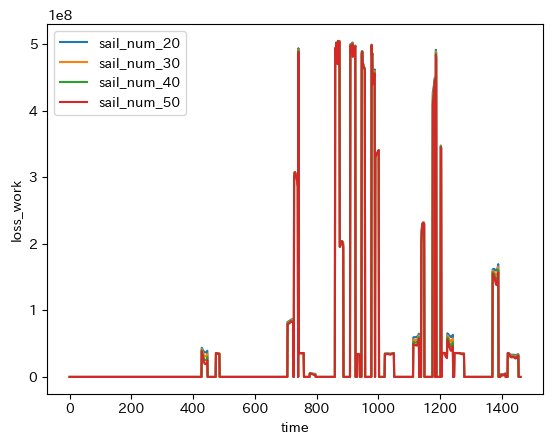

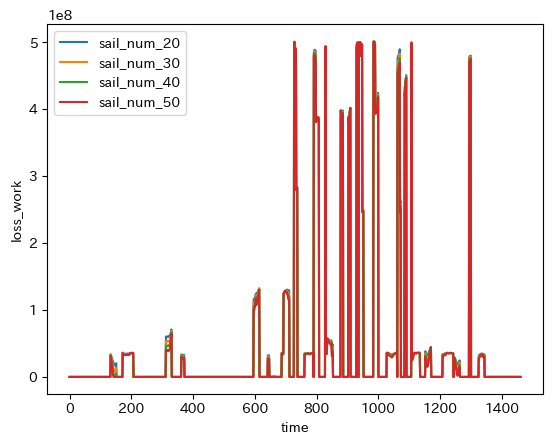

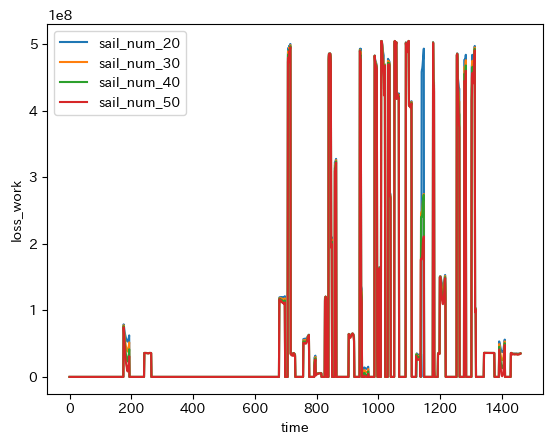

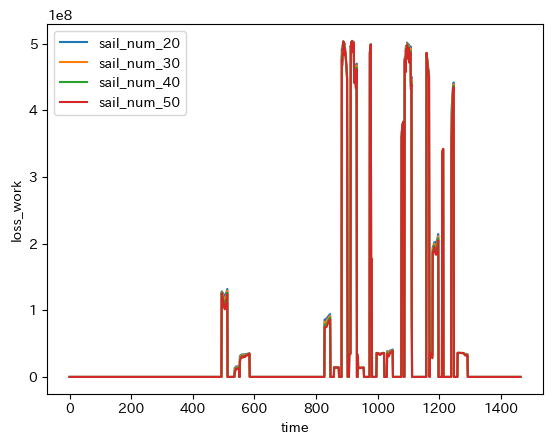

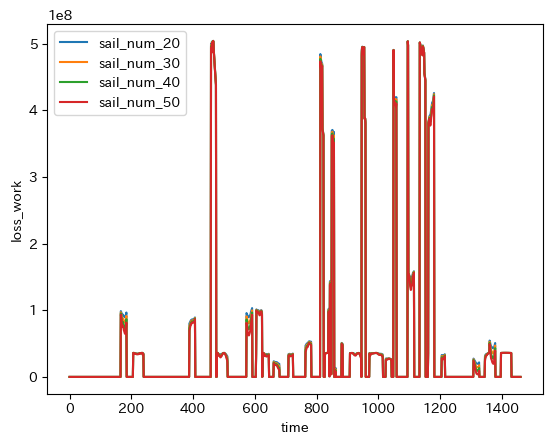

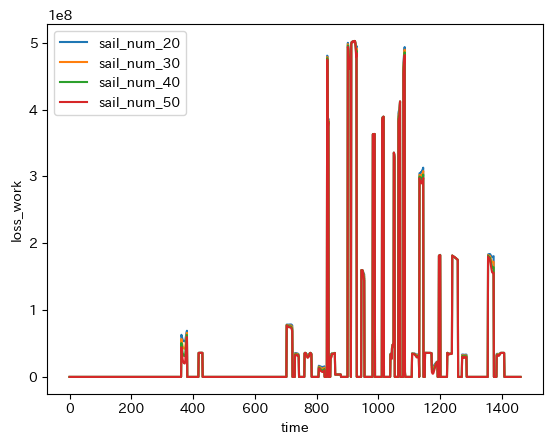

In [84]:
#書き出したデータのグラフ化
#台風発電船の消費仕事量
# データサイズに合わせて横軸に用いる6時間おきの時間のリストを作成
ship_lat_list = pl.read_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_GS_loss.csv")




# 台風発電船の消費仕事量のグラフ化
for y_i in range(6):
    year = 2017 + y_i
    ship_loss_list = pl.read_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_GS_loss.csv")
    time_list = []
    for i in range(len(ship_loss_list)):
        time_list.append(i)
    
    plt.plot(time_list,ship_loss_list["sail_num_20"],label = "sail_num_20")
    plt.plot(time_list,ship_loss_list["sail_num_30"],label = "sail_num_30")
    plt.plot(time_list,ship_loss_list["sail_num_40"],label = "sail_num_40")
    plt.plot(time_list,ship_loss_list["sail_num_50"],label = "sail_num_50")
    plt.xlabel("time")
    plt.ylabel("loss_work")
    plt.legend()
    plt.savefig("output_Folder/TPGship_wind_checker/" + str(year) + "_GS_loss.png")
    plt.show()




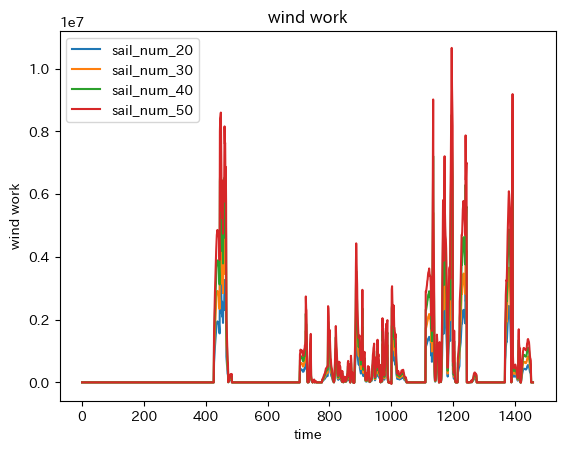

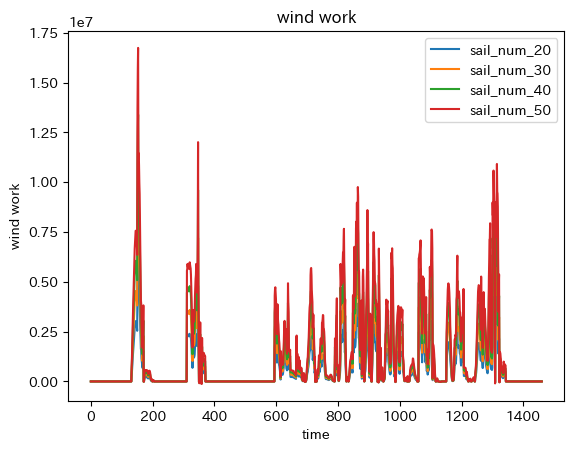

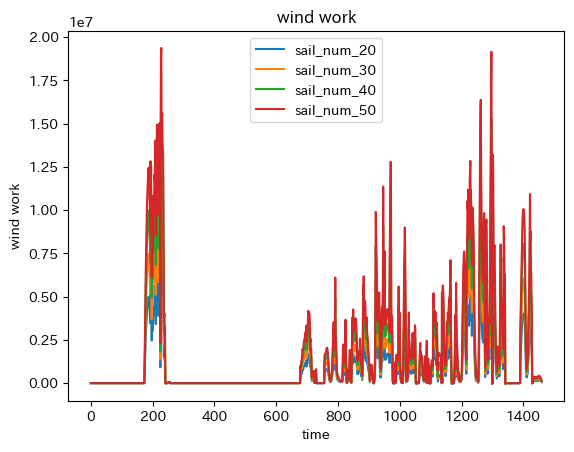

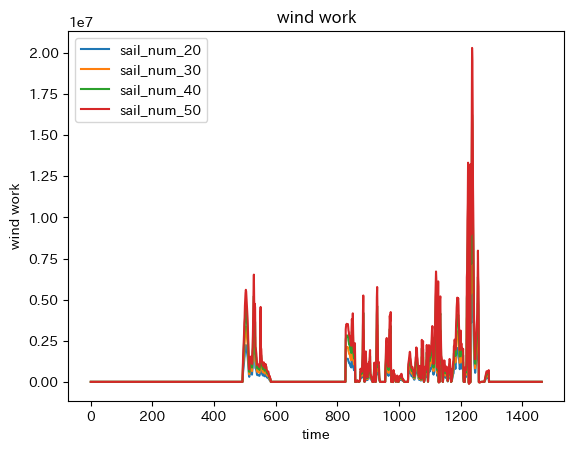

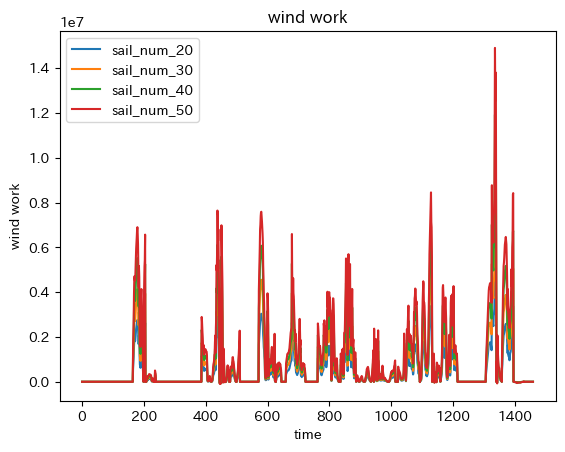

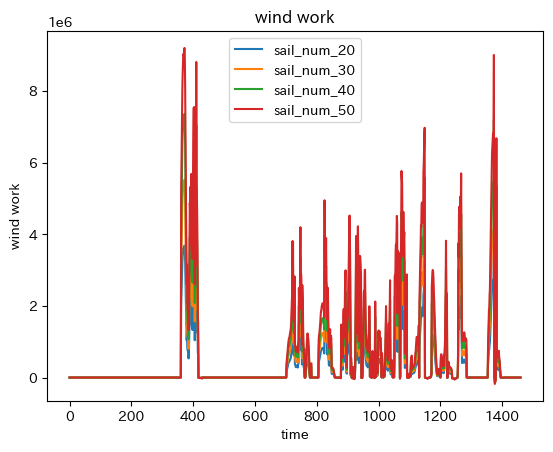

In [87]:
# 台風発電船が受けた風の仕事量のグラフ化
for y_i in range(6):
    year = 2017 + y_i
    wind_work_list = pl.read_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_wind_work.csv")


    # データサイズに合わせて横軸に用いる6時間おきの時間のリストを作成
    time_list = []
    for i in range(len(wind_work_list)):
        time_list.append(i)

    # 台風発電船が受けた風の仕事量のグラフ化
    fig, ax = plt.subplots(1,1)
    ax.plot(time_list, wind_work_list["sail_num_20"], label="sail_num_20")
    ax.plot(time_list, wind_work_list["sail_num_30"], label="sail_num_30")
    ax.plot(time_list, wind_work_list["sail_num_40"], label="sail_num_40")
    ax.plot(time_list, wind_work_list["sail_num_50"], label="sail_num_50")
    ax.set_title("wind work")
    ax.set_xlabel("time")
    ax.set_ylabel("wind work")
    ax.legend()

    plt.show()
    

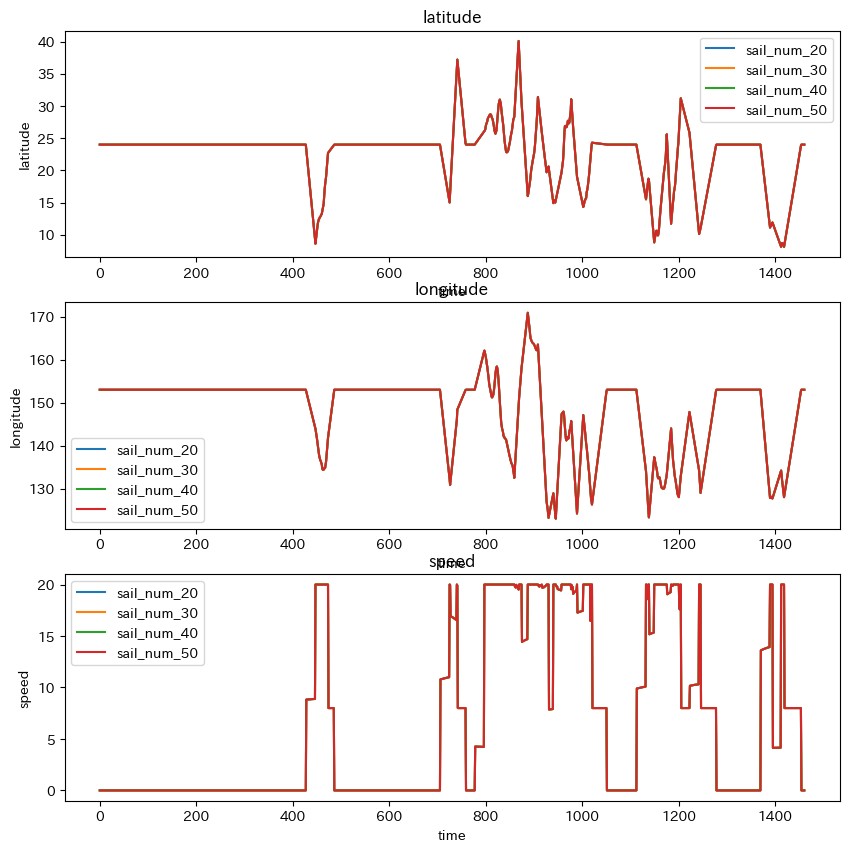

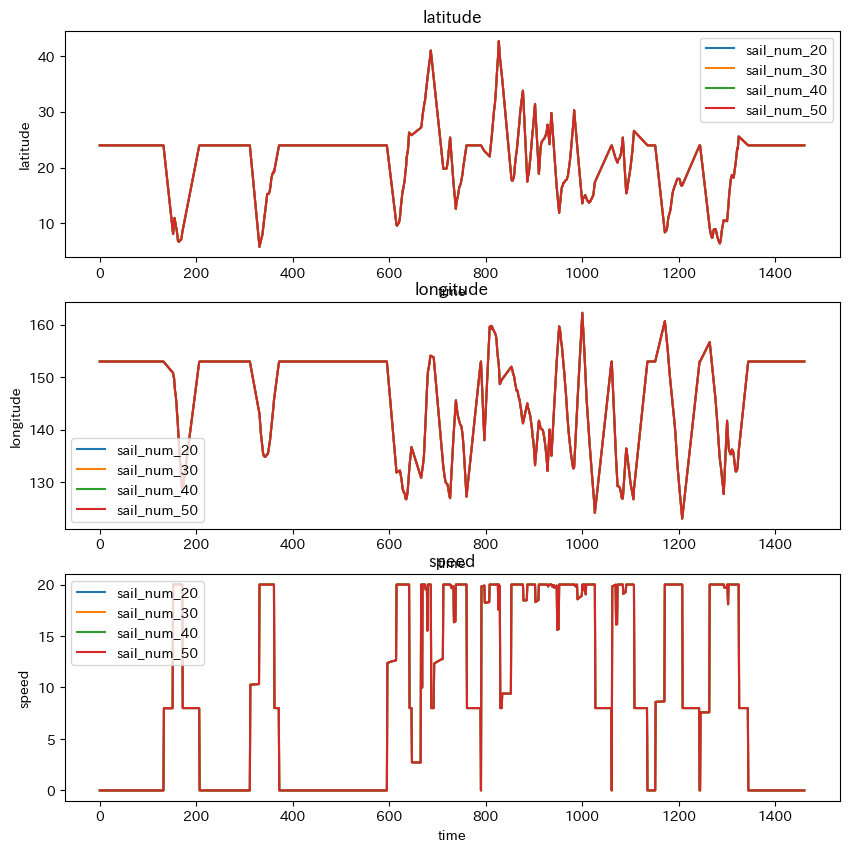

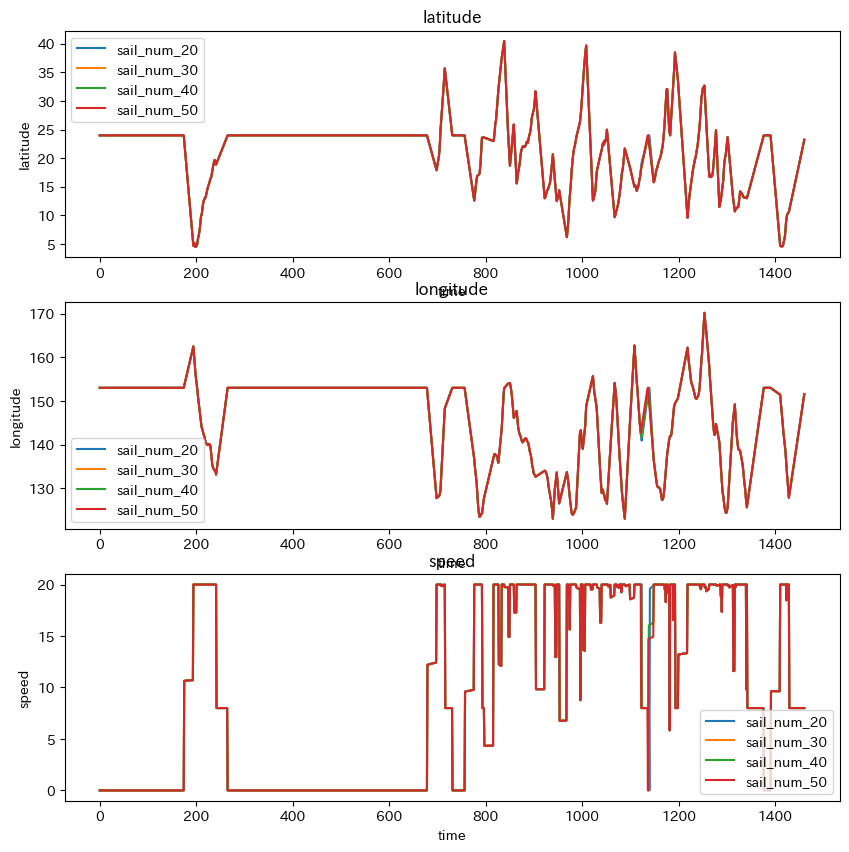

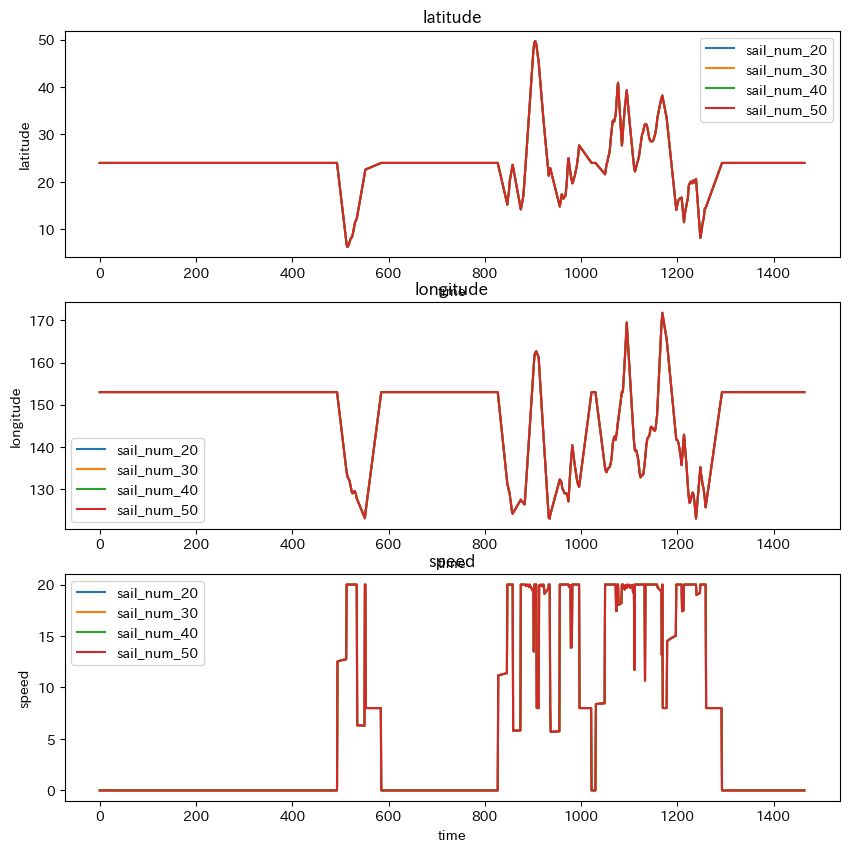

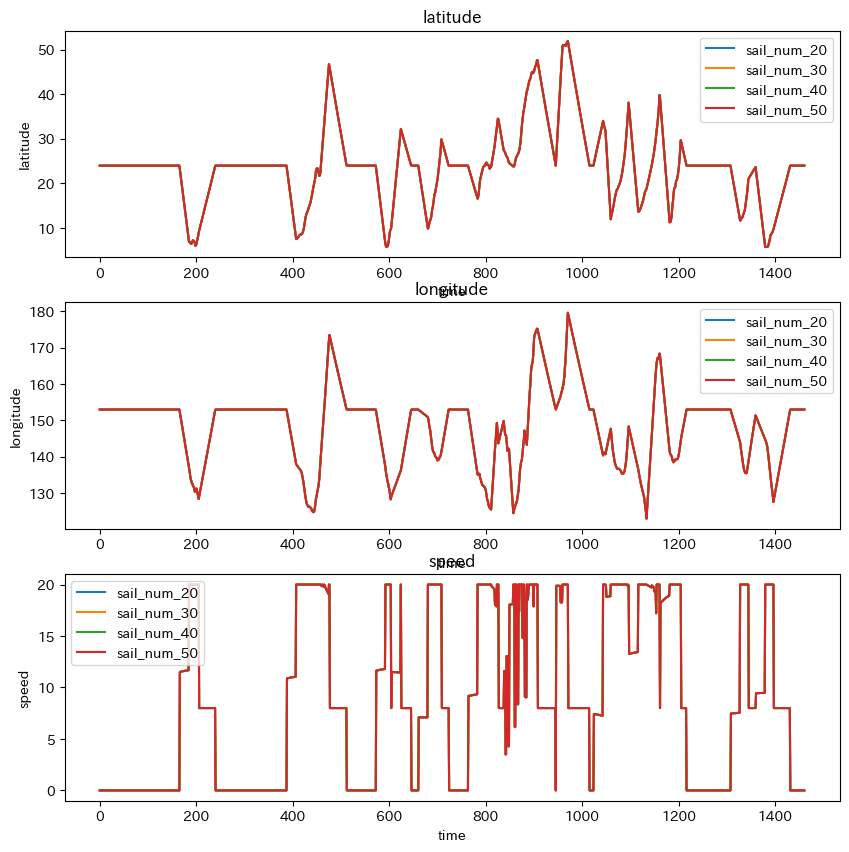

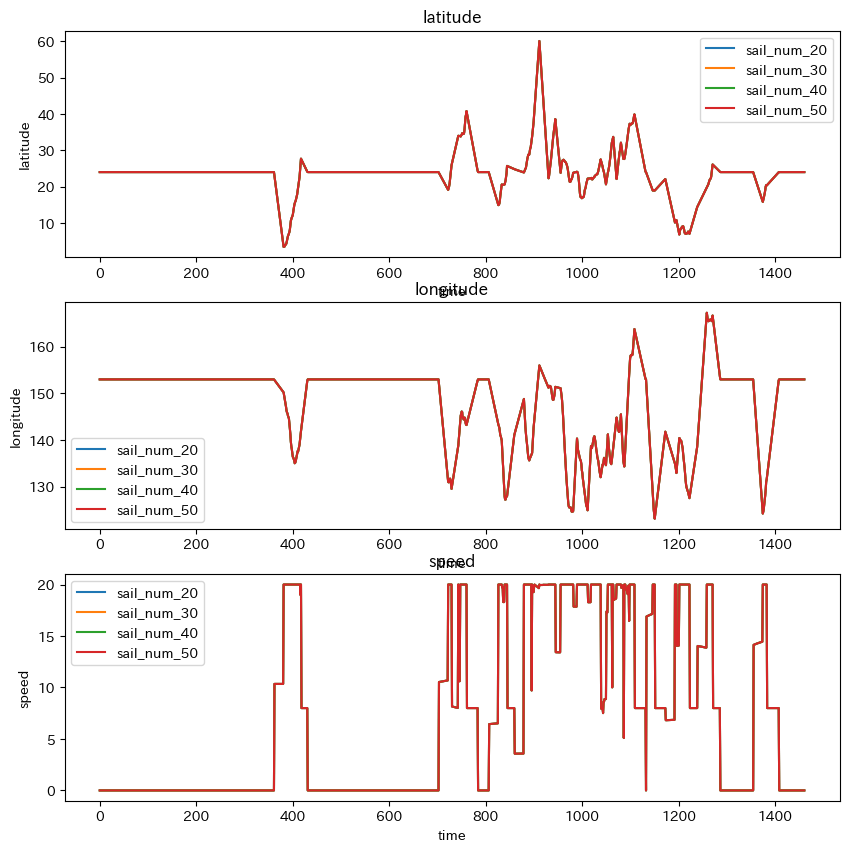

In [ ]:
#書き出した各データのグラフ化
#台風発電船の緯度、経度、船速
# データサイズに合わせて横軸に用いる6時間おきの時間のリストを作成
ship_lat_list = pl.read_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_GS_lat.csv")
time_list = []
for i in range(len(ship_lat_list)):
    time_list.append(i)


# 台風発電船の緯度、経度、船速のグラフ化
for y_i in range(6):
    year = 2017 + y_i
    ship_lat_list = pl.read_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_GS_lat.csv")
    ship_lon_list = pl.read_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_GS_lon.csv")
    ship_speed_list = pl.read_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_GS_speed.csv")

    # データサイズに合わせて横軸に用いる6時間おきの時間のリストを作成
    time_list = []
    for i in range(len(ship_lat_list)):
        time_list.append(i)

    # 台風発電船の緯度、経度、船速のグラフ化
    fig, ax = plt.subplots(3,1,figsize=(10,10))
    ax[0].plot(time_list, ship_lat_list["sail_num_20"], label="sail_num_20")
    ax[0].plot(time_list, ship_lat_list["sail_num_30"], label="sail_num_30")
    ax[0].plot(time_list, ship_lat_list["sail_num_40"], label="sail_num_40")
    ax[0].plot(time_list, ship_lat_list["sail_num_50"], label="sail_num_50")
    ax[0].set_title("latitude")
    ax[0].set_xlabel("time")
    ax[0].set_ylabel("latitude")
    ax[0].legend()

    ax[1].plot(time_list, ship_lon_list["sail_num_20"], label="sail_num_20")
    ax[1].plot(time_list, ship_lon_list["sail_num_30"], label="sail_num_30")
    ax[1].plot(time_list, ship_lon_list["sail_num_40"], label="sail_num_40")
    ax[1].plot(time_list, ship_lon_list["sail_num_50"], label="sail_num_50")
    ax[1].set_title("longitude")
    ax[1].set_xlabel("time")
    ax[1].set_ylabel("longitude")
    ax[1].legend()

    ax[2].plot(time_list, ship_speed_list["sail_num_20"], label="sail_num_20")
    ax[2].plot(time_list, ship_speed_list["sail_num_30"], label="sail_num_30")
    ax[2].plot(time_list, ship_speed_list["sail_num_40"], label="sail_num_40")
    ax[2].plot(time_list, ship_speed_list["sail_num_50"], label="sail_num_50")
    ax[2].set_title("speed")
    ax[2].set_xlabel("time")
    ax[2].set_ylabel("speed")
    ax[2].legend()

    plt.savefig("output_Folder/TPGship_wind_checker/" + str(year) + "_GS_lat_lon_speed.png")
    plt.show()

    


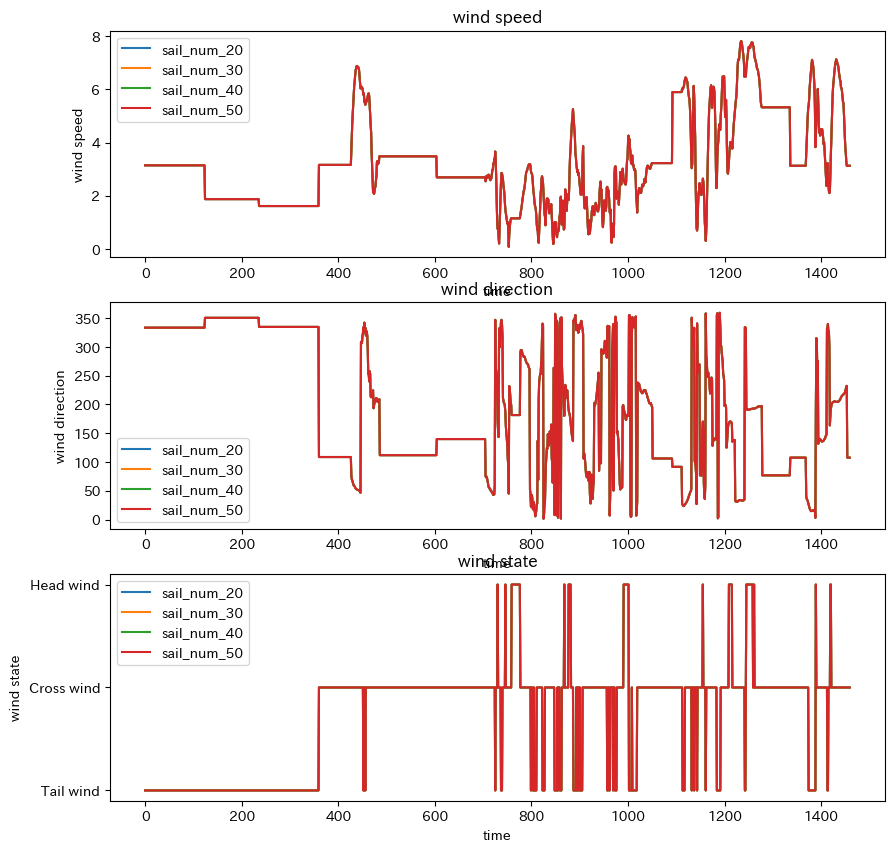

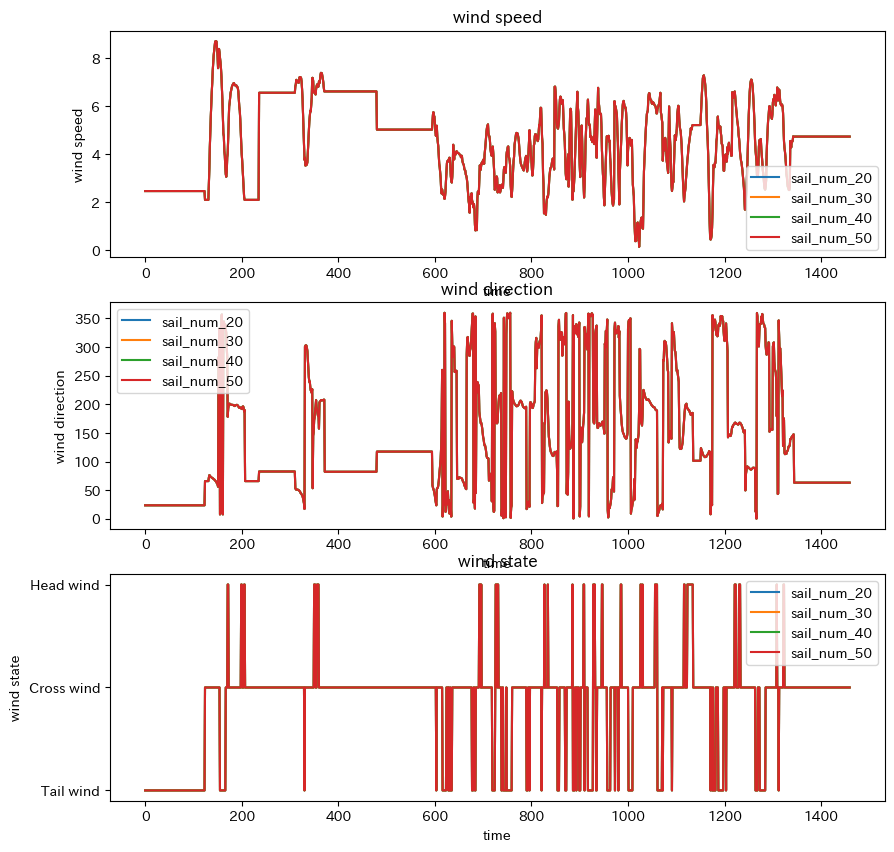

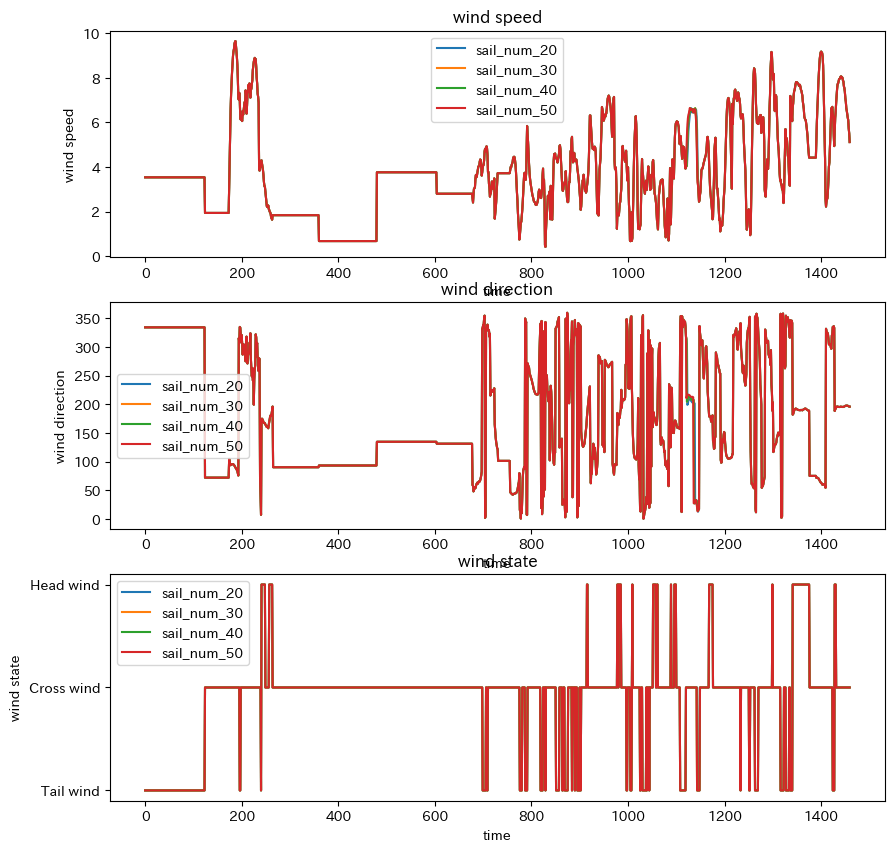

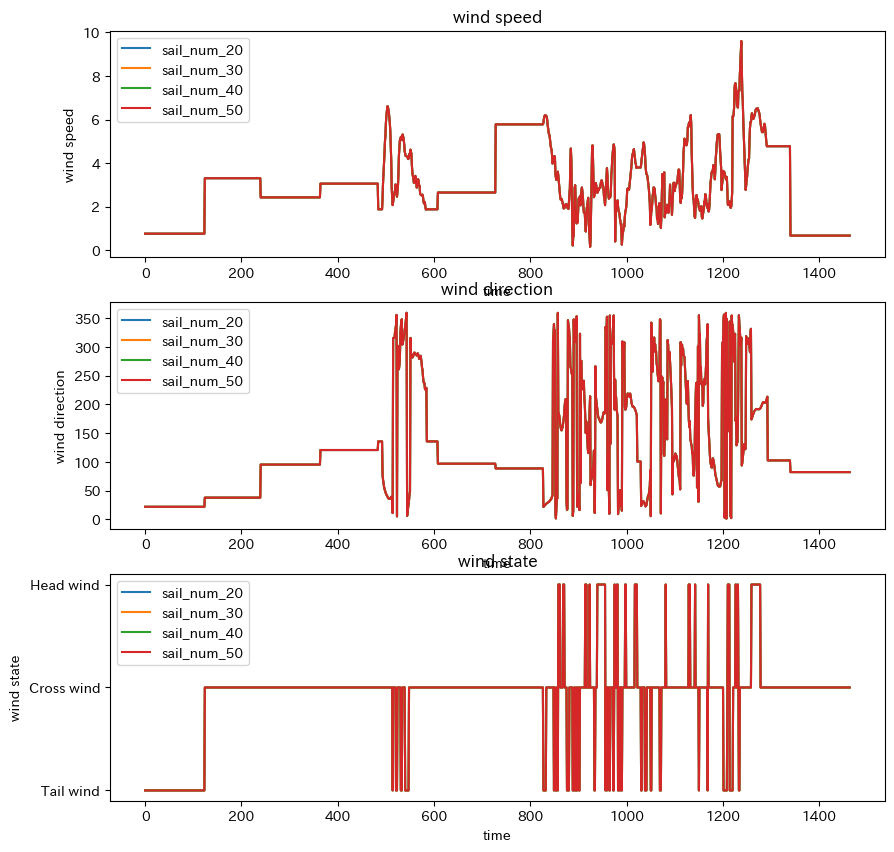

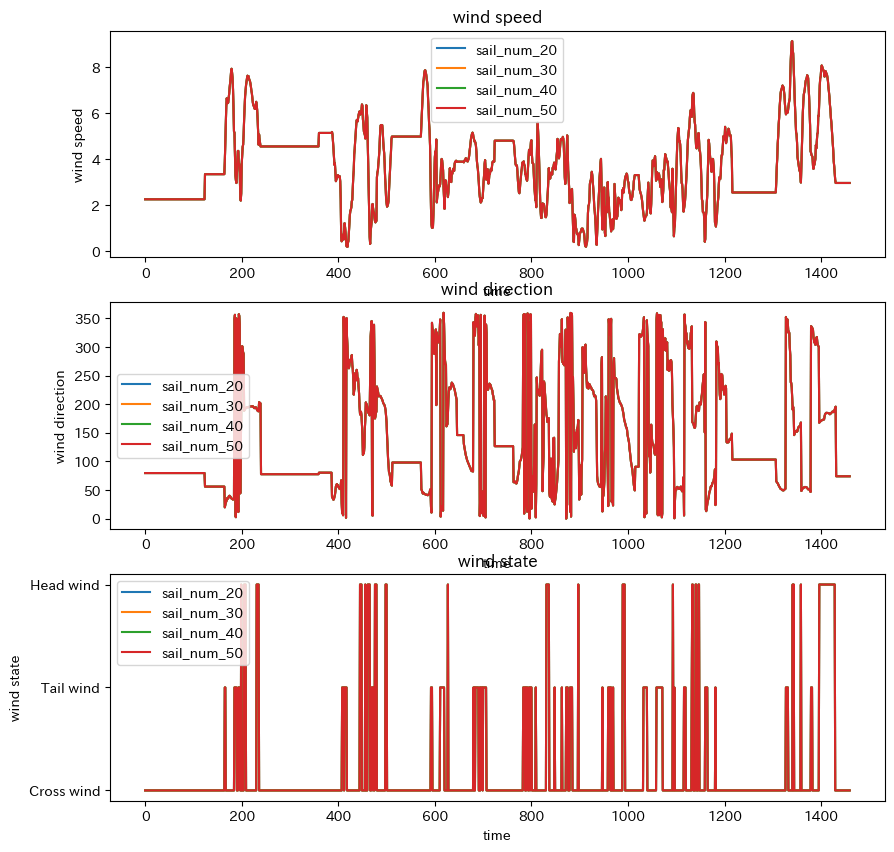

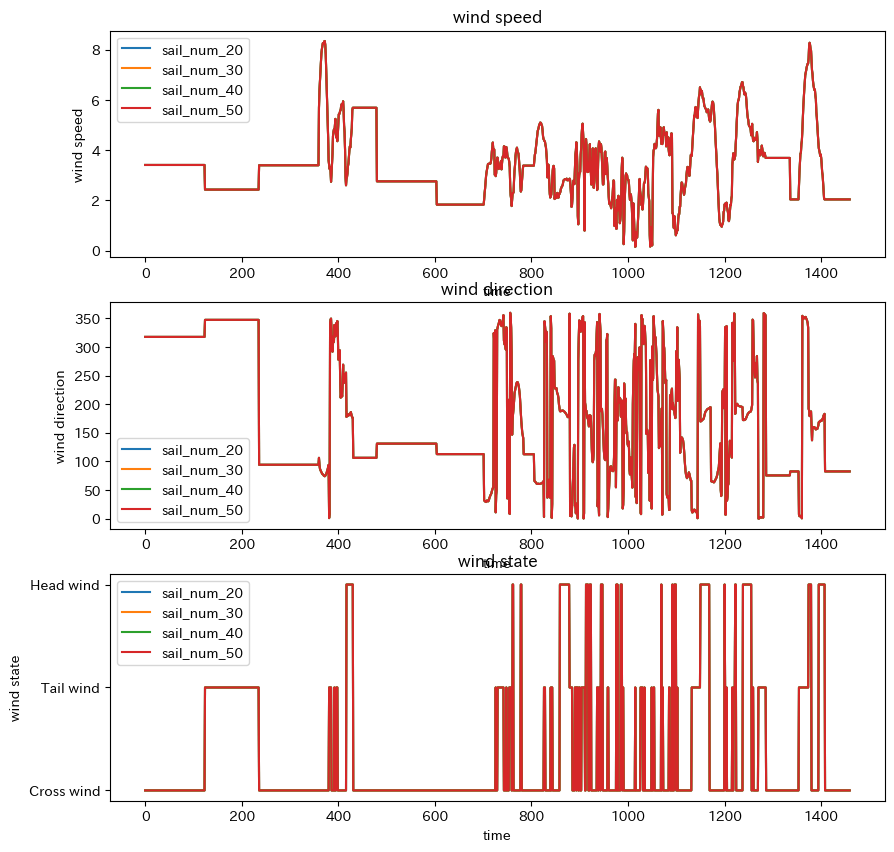

In [ ]:
# 台風発電船が受けた風の速度、方向、状態のグラフ化
for y_i in range(6):
    year = 2017 + y_i
    wind_speed_list = pl.read_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_wind_speed.csv")
    wind_direction_list = pl.read_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_wind_direction.csv")
    wind_state_list = pl.read_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_wind_state.csv")

    # データサイズに合わせて横軸に用いる6時間おきの時間のリストを作成
    time_list = []
    for i in range(len(wind_speed_list)):
        time_list.append(i)

    # 台風発電船が受けた風の速度、方向、状態のグラフ化
    fig, ax = plt.subplots(3,1,figsize=(10,10))
    ax[0].plot(time_list, wind_speed_list["sail_num_20"], label="sail_num_20")
    ax[0].plot(time_list, wind_speed_list["sail_num_30"], label="sail_num_30")
    ax[0].plot(time_list, wind_speed_list["sail_num_40"], label="sail_num_40")
    ax[0].plot(time_list, wind_speed_list["sail_num_50"], label="sail_num_50")
    ax[0].set_title("wind speed")
    ax[0].set_xlabel("time")
    ax[0].set_ylabel("wind speed")
    ax[0].legend()

    ax[1].plot(time_list, wind_direction_list["sail_num_20"], label="sail_num_20")
    ax[1].plot(time_list, wind_direction_list["sail_num_30"], label="sail_num_30")
    ax[1].plot(time_list, wind_direction_list["sail_num_40"], label="sail_num_40")
    ax[1].plot(time_list, wind_direction_list["sail_num_50"], label="sail_num_50")
    ax[1].set_title("wind direction")
    ax[1].set_xlabel("time")
    ax[1].set_ylabel("wind direction")
    ax[1].legend()

    ax[2].plot(time_list, wind_state_list["sail_num_20"], label="sail_num_20")
    ax[2].plot(time_list, wind_state_list["sail_num_30"], label="sail_num_30")
    ax[2].plot(time_list, wind_state_list["sail_num_40"], label="sail_num_40")
    ax[2].plot(time_list, wind_state_list["sail_num_50"], label="sail_num_50")
    ax[2].set_title("wind state")
    ax[2].set_xlabel("time")
    ax[2].set_ylabel("wind state")
    ax[2].legend()

    plt.savefig("output_Folder/TPGship_wind_checker/" + str(year) + "_wind_speed_direction_state.png")
    plt.show()
    

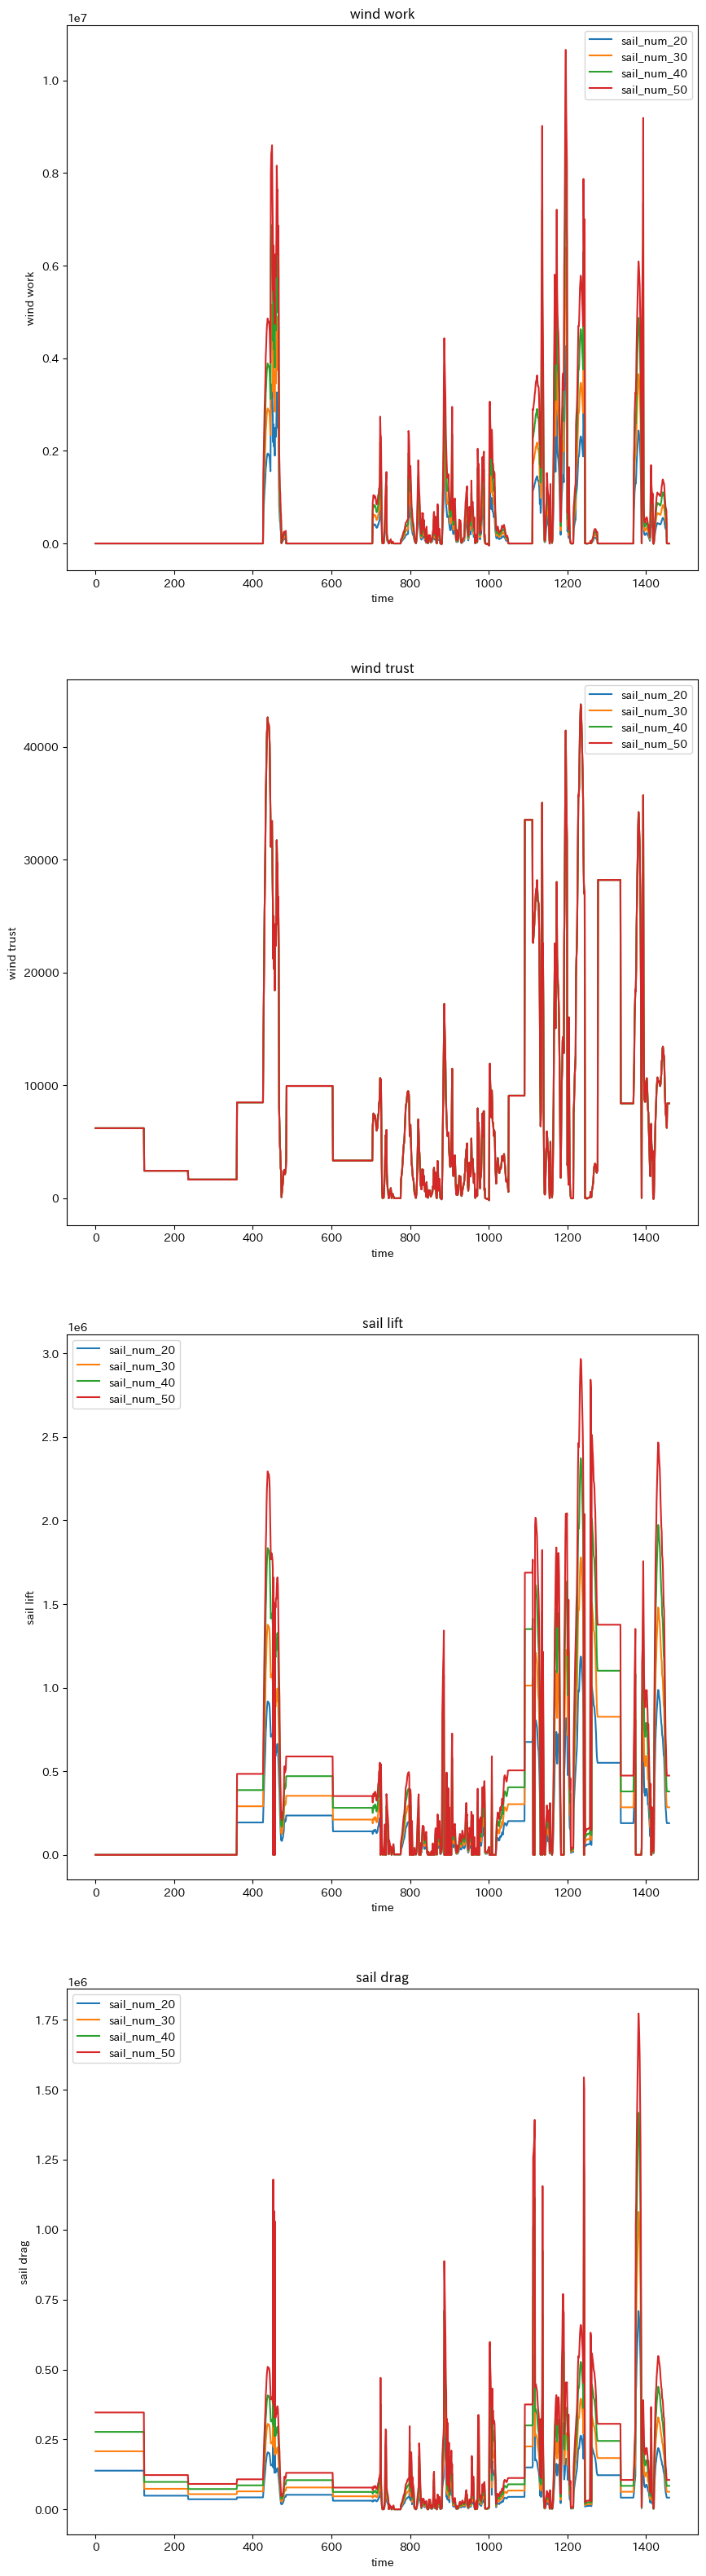

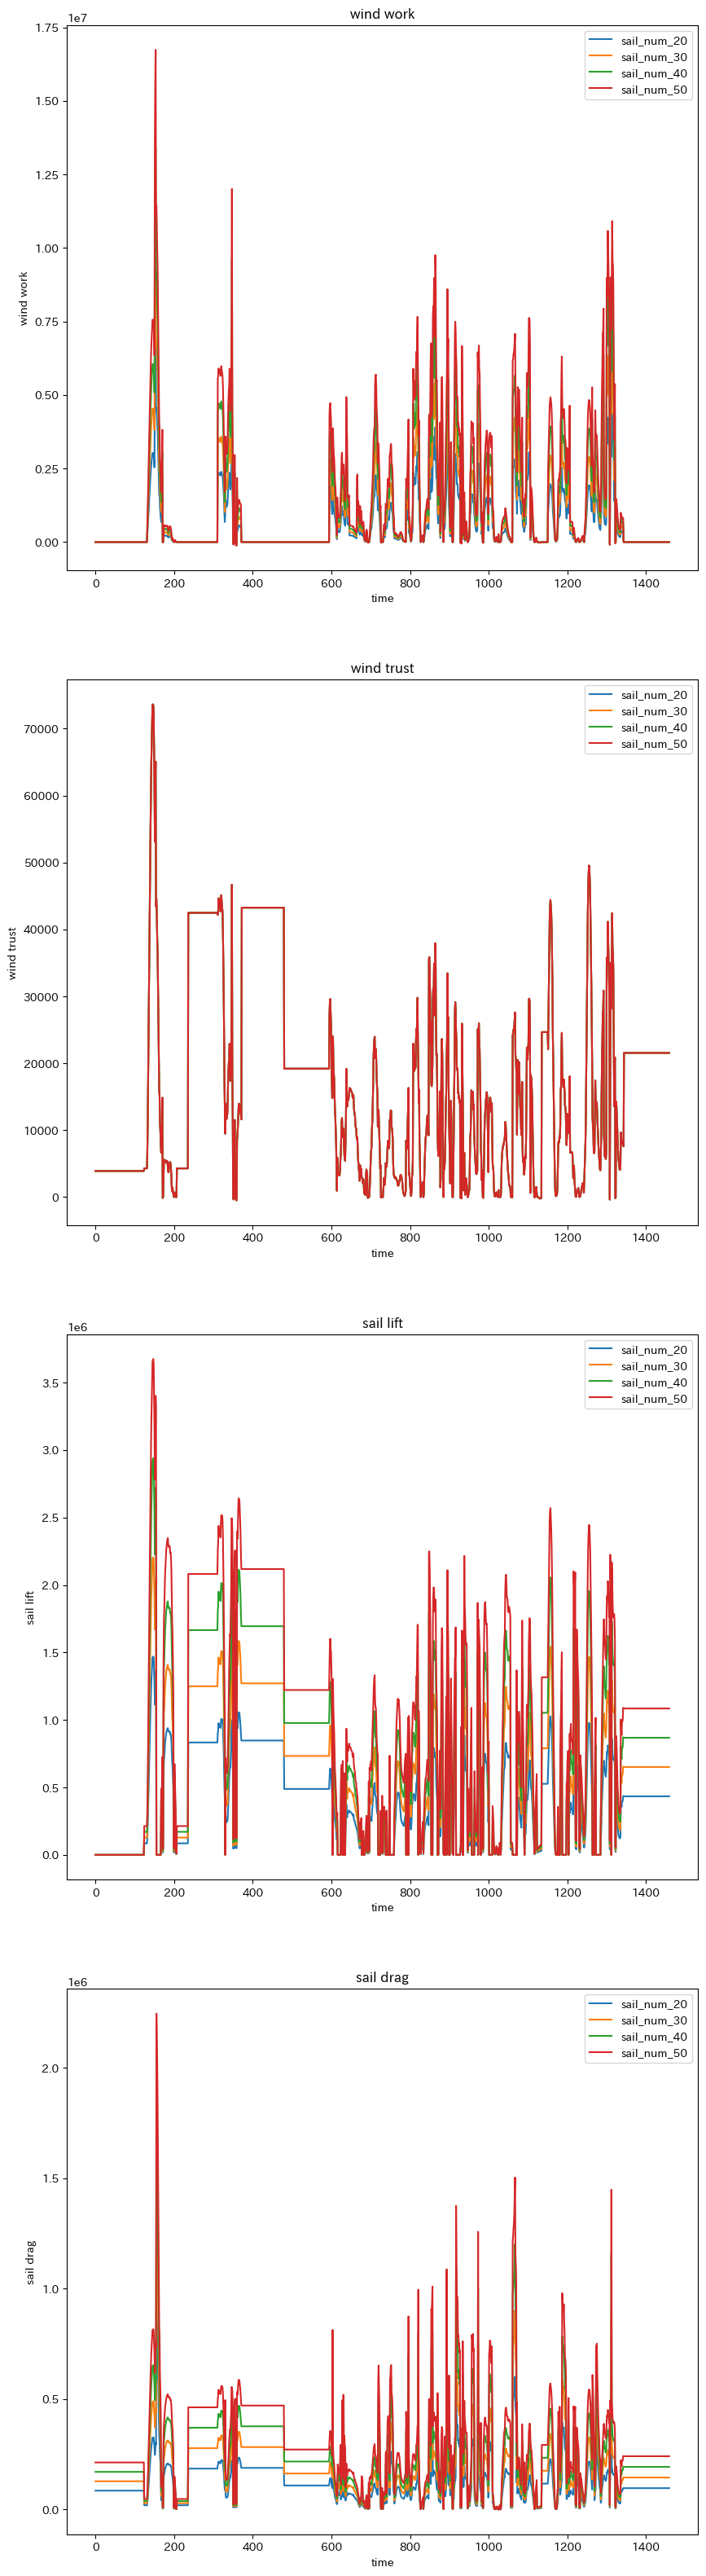

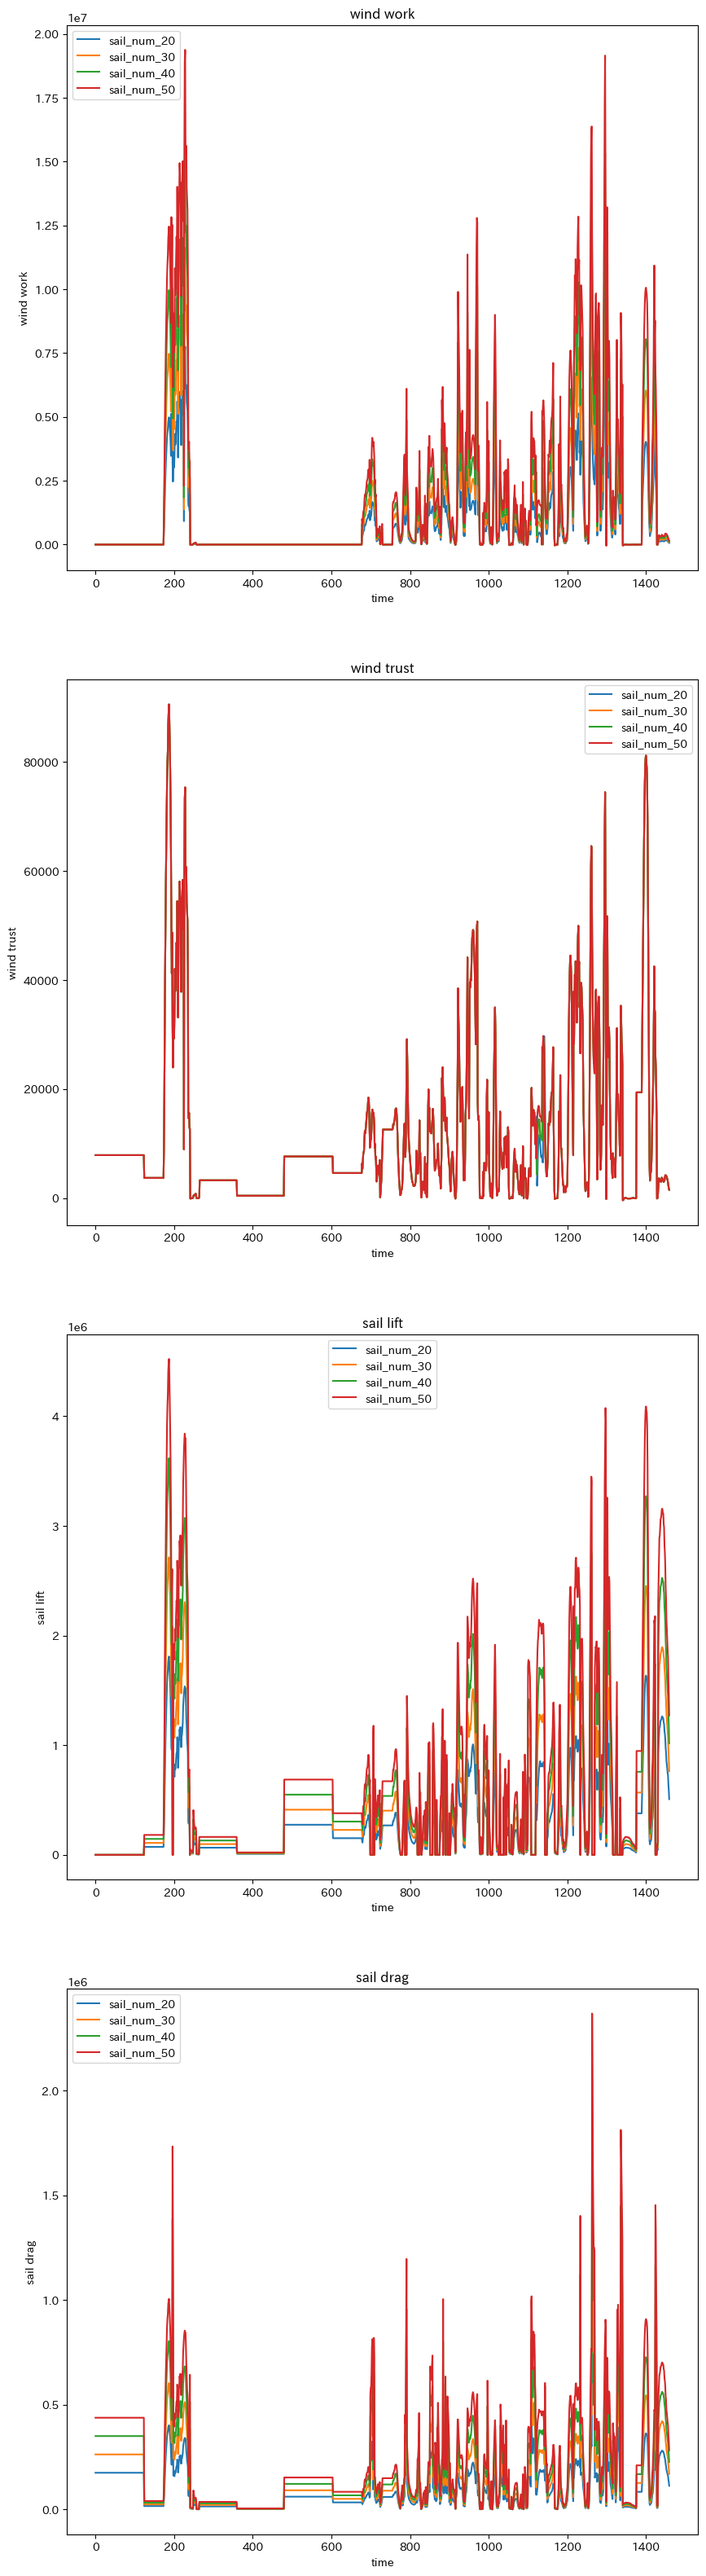

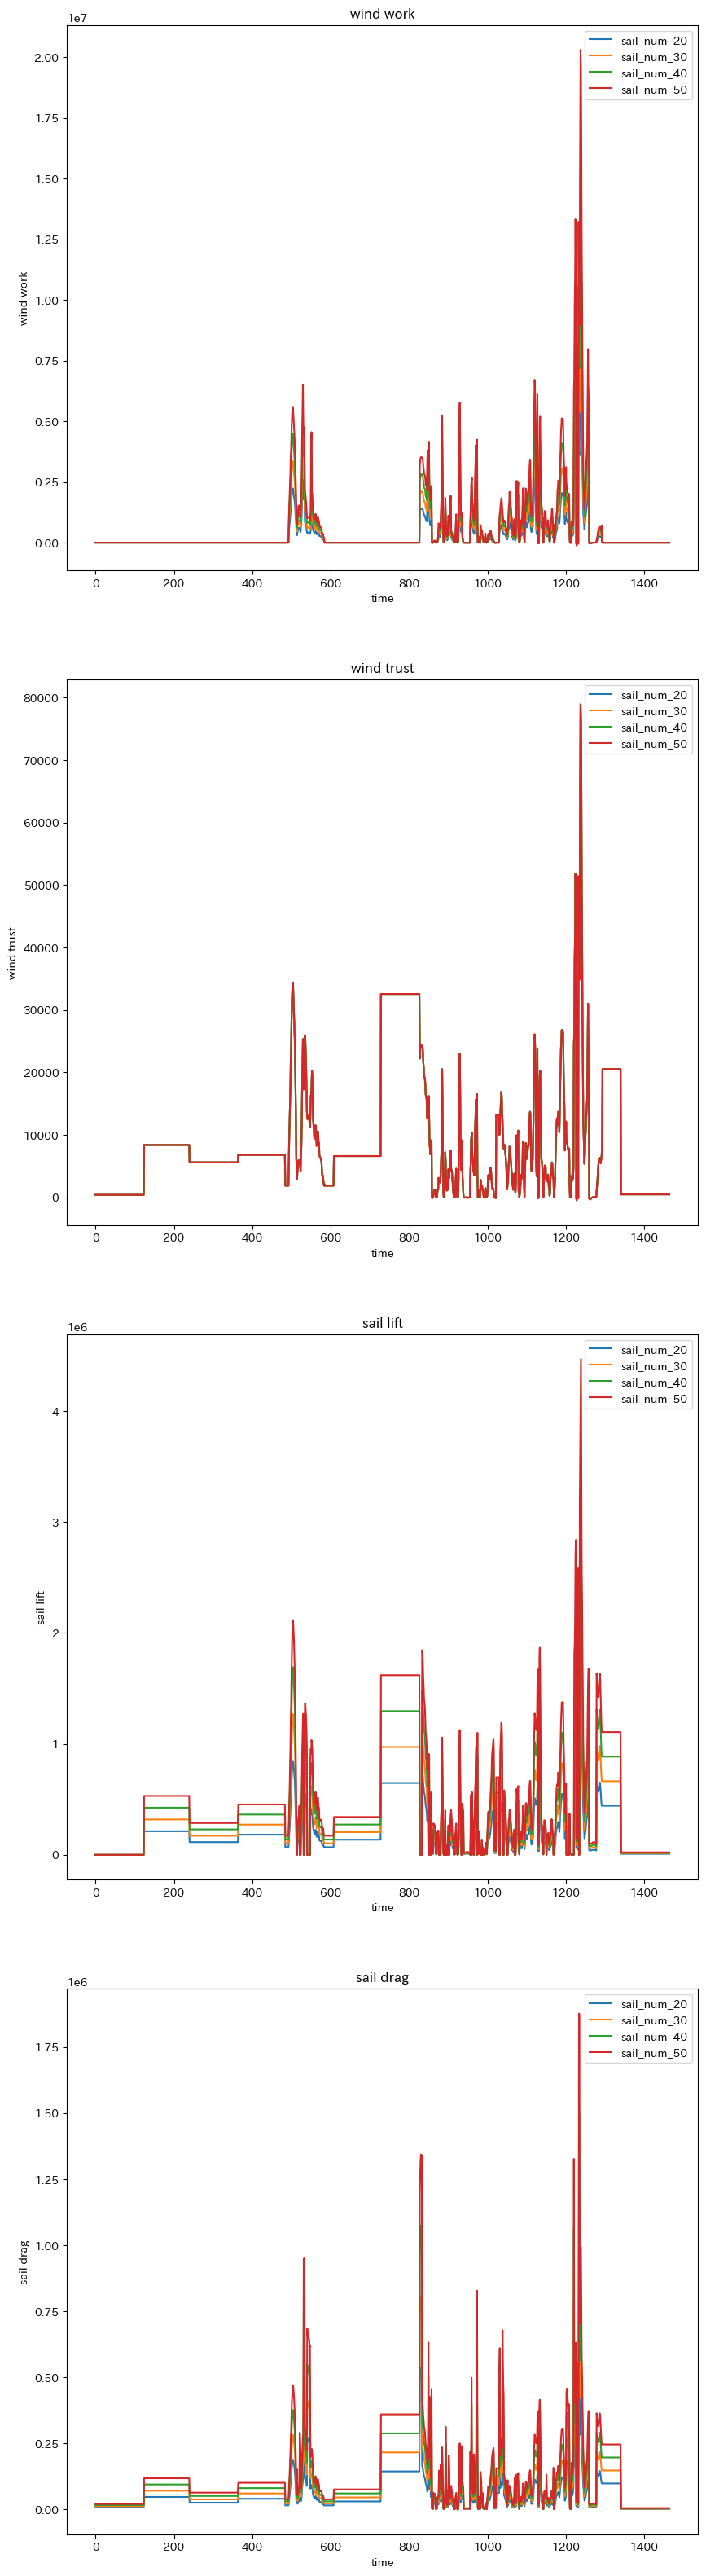

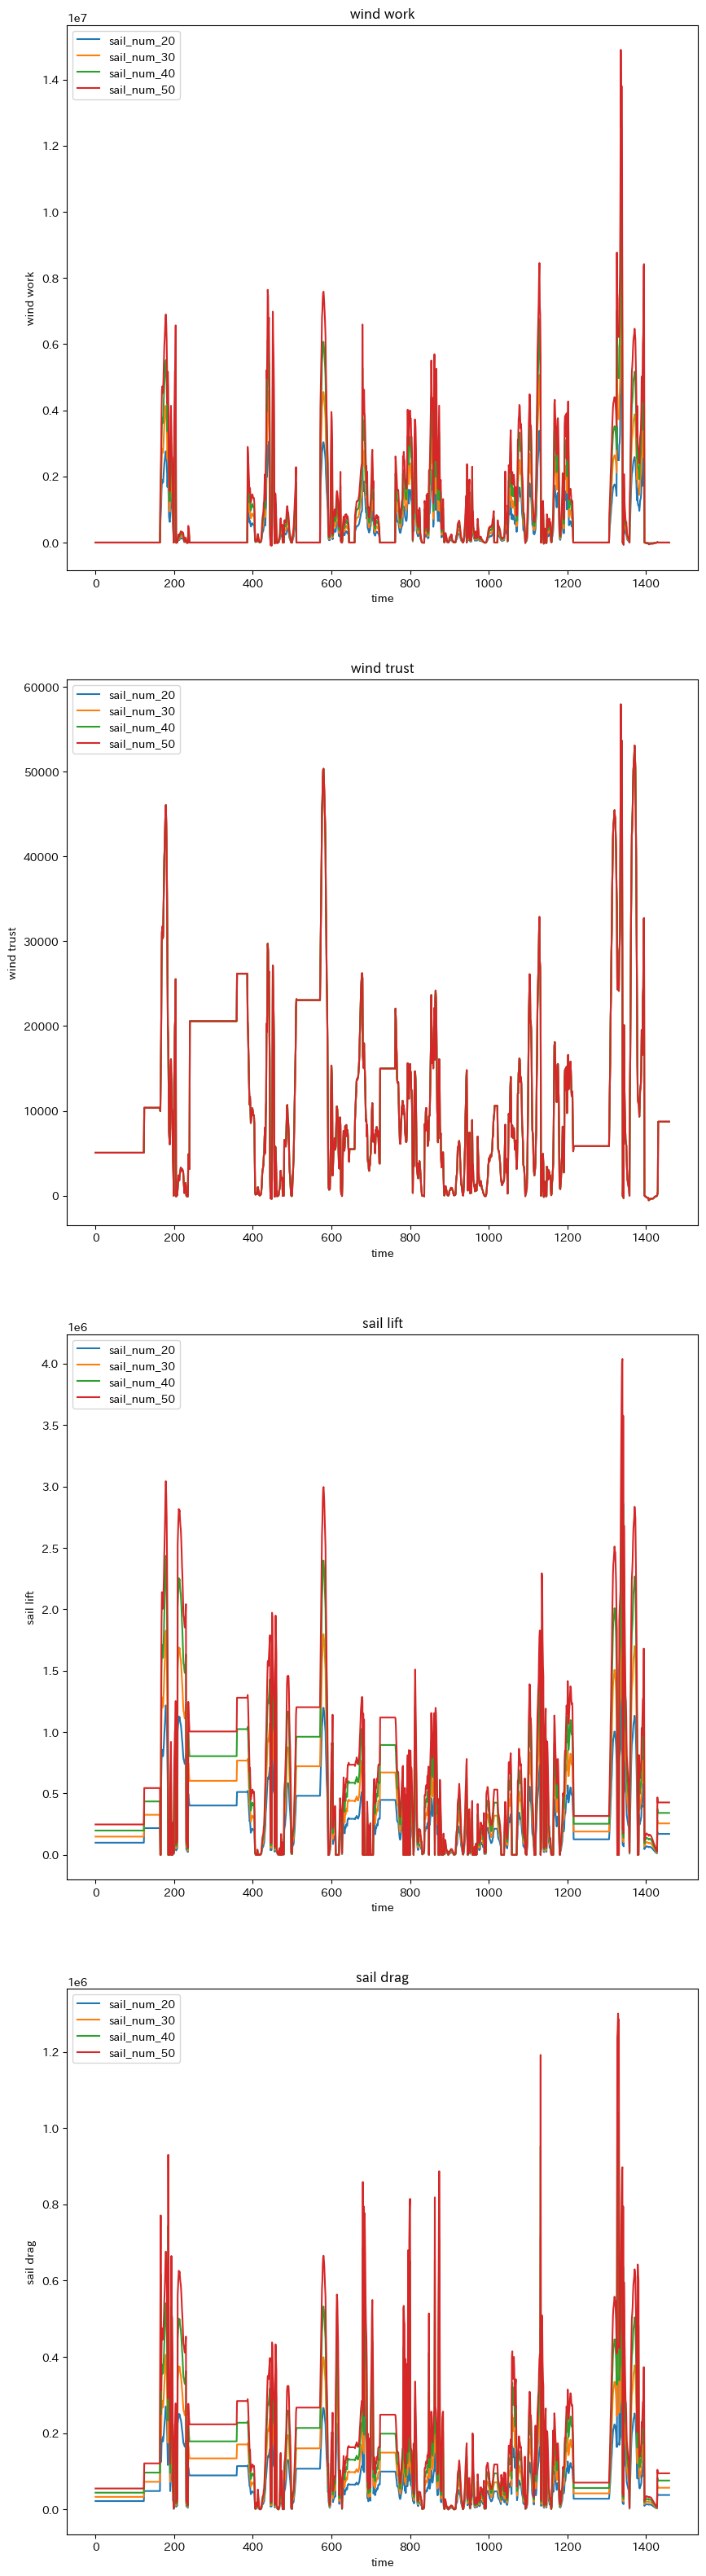

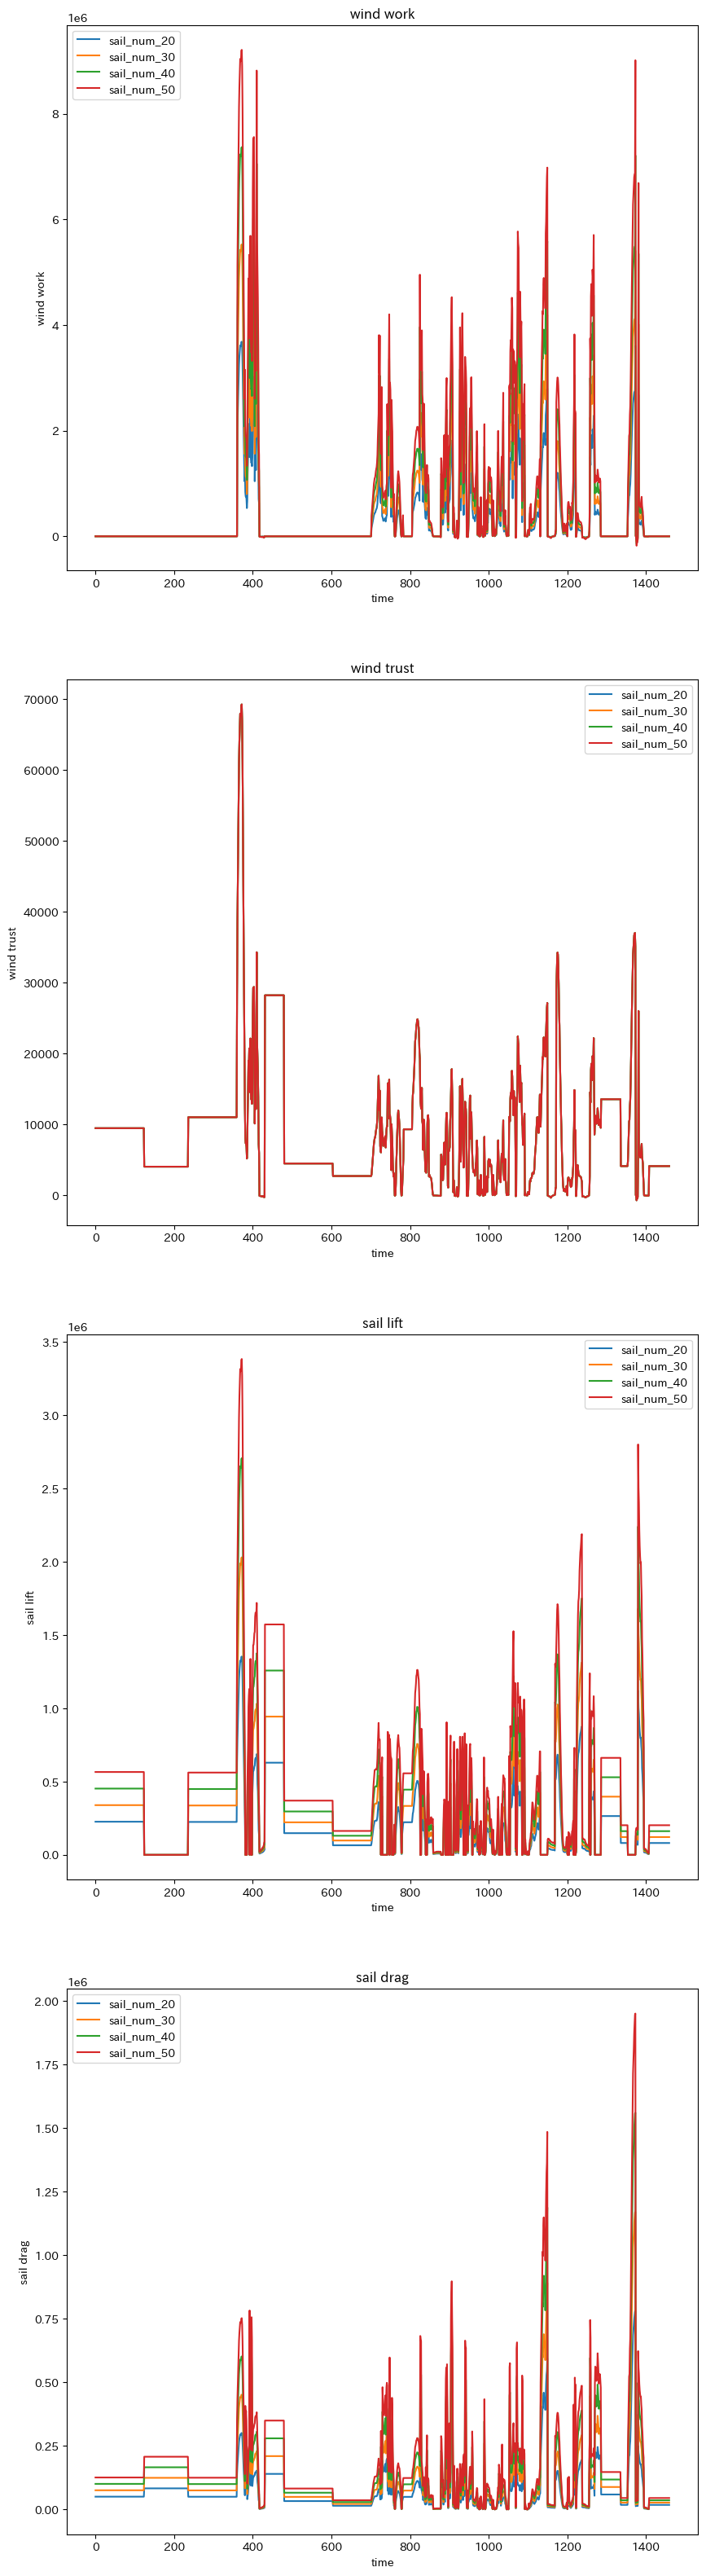

In [ ]:
# 台風発電船が受けた風の仕事量、推進力、揚力、抗力のグラフ化
for y_i in range(6):
    year = 2017 + y_i
    wind_work_list = pl.read_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_wind_work.csv")
    wind_trust_list = pl.read_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_wind_trust.csv")
    sail_lift_list = pl.read_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_sail_lift.csv")
    sail_drag_list = pl.read_csv("output_Folder/TPGship_wind_checker/" + str(year) + "_sail_drag.csv")

    # データサイズに合わせて横軸に用いる6時間おきの時間のリストを作成
    time_list = []
    for i in range(len(wind_work_list)):
        time_list.append(i)

    # 台風発電船が受けた風の仕事量、推進力、揚力、抗力のグラフ化
    fig, ax = plt.subplots(4,1,figsize=(10,40))
    ax[0].plot(time_list, wind_work_list["sail_num_20"], label="sail_num_20")
    ax[0].plot(time_list, wind_work_list["sail_num_30"], label="sail_num_30")
    ax[0].plot(time_list, wind_work_list["sail_num_40"], label="sail_num_40")
    ax[0].plot(time_list, wind_work_list["sail_num_50"], label="sail_num_50")
    ax[0].set_title("wind work")
    ax[0].set_xlabel("time")
    ax[0].set_ylabel("wind work")
    ax[0].legend()

    ax[1].plot(time_list, wind_trust_list["sail_num_20"], label="sail_num_20")
    ax[1].plot(time_list, wind_trust_list["sail_num_30"], label="sail_num_30")
    ax[1].plot(time_list, wind_trust_list["sail_num_40"], label="sail_num_40")
    ax[1].plot(time_list, wind_trust_list["sail_num_50"], label="sail_num_50")
    ax[1].set_title("wind trust")
    ax[1].set_xlabel("time")
    ax[1].set_ylabel("wind trust")
    ax[1].legend()

    ax[2].plot(time_list, sail_lift_list["sail_num_20"], label="sail_num_20")
    ax[2].plot(time_list, sail_lift_list["sail_num_30"], label="sail_num_30")
    ax[2].plot(time_list, sail_lift_list["sail_num_40"], label="sail_num_40")
    ax[2].plot(time_list, sail_lift_list["sail_num_50"], label="sail_num_50")
    ax[2].set_title("sail lift")
    ax[2].set_xlabel("time")
    ax[2].set_ylabel("sail lift")
    ax[2].legend()

    ax[3].plot(time_list, sail_drag_list["sail_num_20"], label="sail_num_20")
    ax[3].plot(time_list, sail_drag_list["sail_num_30"], label="sail_num_30")
    ax[3].plot(time_list, sail_drag_list["sail_num_40"], label="sail_num_40")
    ax[3].plot(time_list, sail_drag_list["sail_num_50"], label="sail_num_50")
    ax[3].set_title("sail drag")
    ax[3].set_xlabel("time")
    ax[3].set_ylabel("sail drag")
    ax[3].legend()

    plt.savefig("output_Folder/TPGship_wind_checker/" + str(year) + "_wind_work_trust_lift_drag.png")
    plt.show()
    

13.962642596401421


In [42]:

ship1.GS_gene_judge = 1
wind_direction = 30

timestep = 6


13.962642596401421
